**IMPORT GOOGLE DRIVE TO COLAB**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

best_model_path = '/content/drive/My Drive/best_model_resnet18.pth'
best_model_path_hybrid = '/content/drive/My Drive/best_model_hybrid_finetune.pth'
best_model_path_hybrid2 = '/content/drive/My Drive/best_model_hybrid_finetune2.pth'

Mounted at /content/drive


**IMPORT ALL THE LIBARIES**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from scipy.stats import wilcoxon
import random
import torchvision.models as models
import scipy.stats as stats
import statsmodels.api as sm
from scipy.stats import rankdata



**STRUCTURE OF RESNET-18 TO LOAD THE SAVED MODEL FOR RESNET-18**

In [2]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        # out = F.avg_pool2d(out, 4)
        out = F.adaptive_avg_pool2d(out, (1, 1)) #another way of doing average pooling
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


model = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=10)
model_resnet = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=10)

**STRUCTURE OF TRANSFORMER BLOCK**

In [3]:
class TransformerEncoderLayer(nn.Module):
    def __init__(self, in_channels, dim_feedforward=2048, nhead=4, dropout=0.1, expansion=2):
        super(TransformerEncoderLayer, self).__init__()
        self.expansion = expansion
        self.self_attn = nn.MultiheadAttention(embed_dim=in_channels, num_heads=nhead, dropout=dropout, batch_first=True)

        self.linear1 = nn.Linear(in_channels, dim_feedforward)
        self.linear2 = nn.Linear(dim_feedforward, in_channels * self.expansion)
        self.dropout = nn.Dropout(dropout)
        self.norm1 = nn.LayerNorm(in_channels)
        self.norm2 = nn.LayerNorm(in_channels * self.expansion)
        self.activation = nn.ReLU()
        self.channel_upscale = nn.Conv2d(in_channels, in_channels * self.expansion, kernel_size=1)

    def forward(self, src):
        batch_size, channels, height, width = src.size()

        # Reshape and permute src for attention
        src_flat = src.permute(0, 2, 3, 1).reshape(batch_size, height * width, channels)  # [batch, C, H, W] -> [batch, H*W, C]
        #print("shape of src flat",src_flat.shape)

        attn_output, _ = self.self_attn(src_flat, src_flat, src_flat)
        attn_output = attn_output.reshape(batch_size, height, width, channels).permute(0, 1, 2, 3)  # Reshape back to [batch, C, H, W]
        #print(attn_output.shape)
        #print(src.shape)

        src = src.reshape(batch_size, height, width, channels).permute(0, 1, 2, 3)  # Reshape from [batch, C, H, W] -> [batch, H, W, C]
        #print(src.shape)

        src = src + self.dropout(attn_output)
        #print(src.shape)
        src = self.norm1(src)

        # Flatten for feedforward layers
        src_view = src.view(batch_size, channels, -1).transpose(1, 2)  # [batch, H*W, C]
        ff_output = self.linear1(src_view)
        ff_output = self.activation(ff_output)
        ff_output = self.dropout(ff_output)
        ff_output = self.linear2(ff_output)
        ff_output = ff_output.transpose(1, 2).view(batch_size, channels * self.expansion, height, width)

        # Apply dropout before adding
        ff_output = self.dropout(ff_output)

        #print("ff output:",ff_output.shape)

        src = src.reshape(batch_size, channels, height, width).permute(0, 1, 3, 2)  # Reshape from [batch, H, W, C] -> [batch, C, H, W]

        # If expansion is not 1
        if self.expansion != 1:
            src = self.channel_upscale(src)  # Upscale src to match the expanded ff_output

        #print("src original:",src.shape)

        batch_size, channels, height, width = src.size()

        src = src + ff_output

        src = src.reshape(batch_size, height, width, channels).permute(0, 1, 2, 3)  # Reshape to [batch, H, W, C]
        #print("src changed:",src.shape)

        src = self.norm2(src)

        src = src.reshape(batch_size, channels, height, width).permute(0, 1, 3, 2)  # Reshape to [batch, C, H, W]

        return src


m = TransformerEncoderLayer(256)

print(m)

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
  )
  (linear1): Linear(in_features=256, out_features=2048, bias=True)
  (linear2): Linear(in_features=2048, out_features=512, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (activation): ReLU()
  (channel_upscale): Conv2d(256, 512, kernel_size=(1, 1), stride=(1, 1))
)


**STRUCTURE OF HYBRID MODEL**

In [4]:
class ModifiedResNet18(nn.Module):
    def __init__(self):
        super(ModifiedResNet18, self).__init__()
        self.resnet = model_resnet
        # self.resnet.layer4 = TransformerEncoderLayer(256,expansion=2)
        self.resnet.layer4 = TransformerEncoderLayer(in_channels=256, expansion=2, dim_feedforward=2048, nhead=4)
        self.resnet.fc = nn.Linear(512, 10)

    def forward(self, x):
        return self.resnet(x)


model_hybrid = ModifiedResNet18()
model_hybrid2 = ModifiedResNet18()



**LOADING AND TRANSFORMING DATASET (CIFAR-10)**

In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))

# Move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model_hybrid.to(device)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform_test)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)


100%|██████████| 170M/170M [00:18<00:00, 9.09MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


**LOADING THE SAVED WEIGHTS OF RESNET-18 MODEL IN THIS MODEL**

In [6]:
# loading resnet 18 model
model.load_state_dict(torch.load(best_model_path))

model.eval()

<ipython-input-6-c84ca8ae5e53>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

**LOADING WEIGHTS OF SAVED HYBRID MODEL (USED IN ANALYSIS)**

In [8]:
# loading hybrid 2 model

model_hybrid2.load_state_dict(torch.load(best_model_path_hybrid2))

model_hybrid2.eval()

<ipython-input-8-04071f6134fe>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_hybrid2.load_state_dict(torch.load(best_model_path_hybrid2))


ModifiedResNet18(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (shortcut): Sequential()
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   

**LOADING SAVED WEIGHTS OF HYBRID MODEL FROM THE EXTRA CODE (NOT USED IN THESIS)**

In [7]:
# loading hybrid 1 model

model_hybrid.load_state_dict(torch.load(best_model_path_hybrid))

model_hybrid.eval()

<ipython-input-7-73b8d6734b91>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_hybrid.load_state_dict(torch.load(best_model_path_hybrid))


ModifiedResNet18(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (shortcut): Sequential()
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   

# **CHECKING THE WEIGHTS OF RESNET-18 AND HYBRID MODEL**

In [9]:
# weights of resnet 18 model
print(model.state_dict().values())

odict_values([tensor([[[[ 2.9250e-01,  2.6980e-01, -2.5840e-01],
          [ 1.7041e-01, -2.3232e-01,  7.4738e-03],
          [ 2.3035e-01, -1.1091e-01, -1.3185e-01]],

         [[ 7.1207e-02,  2.0336e-01,  5.2921e-02],
          [ 2.3874e-03, -4.4237e-01,  2.8700e-01],
          [ 3.0846e-01, -2.8681e-03,  1.5267e-02]],

         [[-2.4118e-01, -1.9261e-01, -1.1068e-01],
          [-2.1741e-01, -3.6040e-01,  3.5695e-01],
          [-9.2159e-02,  2.7839e-01,  3.1892e-01]]],


        [[[ 1.1929e-02, -6.2267e-02, -2.0668e-01],
          [-4.2173e-02,  1.9223e-01,  2.2518e-01],
          [-5.7876e-01, -5.1325e-02,  1.8938e-01]],

         [[-5.9838e-02,  5.0171e-02,  8.2755e-03],
          [ 1.1613e-01,  1.7212e-01,  3.4075e-01],
          [-4.6530e-01,  7.0331e-02,  1.1293e-01]],

         [[ 2.0831e-01, -3.1970e-01, -4.6741e-01],
          [ 2.4373e-01, -5.7868e-02, -2.2289e-01],
          [-1.8128e-01,  2.2364e-01,  1.6058e-01]]],


        [[[-2.9235e-01, -3.7476e-01, -3.4532e-01],
 

In [ ]:
# weights of finetuned hybrid model
print(model_hybrid.state_dict().values())

odict_values([tensor([[[[ 3.2464e-01,  3.3628e-01, -3.0472e-01],
          [ 1.7223e-01, -3.8333e-01, -5.6579e-02],
          [ 3.2148e-01, -1.0294e-01, -2.4688e-01]],

         [[ 1.0990e-01,  2.8581e-01,  8.8194e-02],
          [-6.2094e-03, -5.7158e-01,  3.1865e-01],
          [ 4.0096e-01,  5.7009e-02, -9.7243e-04]],

         [[-3.4950e-01, -2.3086e-01, -1.1308e-01],
          [-3.3884e-01, -4.4973e-01,  4.5414e-01],
          [-1.4594e-01,  3.0519e-01,  3.9476e-01]]],


        [[[ 5.7015e-02, -7.5144e-02, -2.3700e-01],
          [-7.6484e-02,  1.9053e-01,  2.3982e-01],
          [-6.8046e-01, -7.4638e-02,  2.1113e-01]],

         [[ 6.9657e-02,  5.9040e-02, -1.7334e-02],
          [ 1.3004e-01,  1.7304e-01,  3.6118e-01],
          [-5.2195e-01,  8.7247e-02,  1.7524e-01]],

         [[ 3.9838e-01, -3.7117e-01, -6.8267e-01],
          [ 4.6419e-01, -6.6321e-02, -3.6219e-01],
          [ 1.7239e-02,  2.8967e-01,  1.1242e-01]]],


        [[[-4.3939e-01, -5.3018e-01, -4.7578e-01],
 

In [35]:
# weights of finetuned hybrid2 model
print(model_hybrid2.state_dict().values())

odict_values([tensor([[[[ 3.2464e-01,  3.3628e-01, -3.0472e-01],
          [ 1.7223e-01, -3.8333e-01, -5.6579e-02],
          [ 3.2148e-01, -1.0294e-01, -2.4688e-01]],

         [[ 1.0990e-01,  2.8581e-01,  8.8194e-02],
          [-6.2094e-03, -5.7158e-01,  3.1865e-01],
          [ 4.0096e-01,  5.7009e-02, -9.7243e-04]],

         [[-3.4950e-01, -2.3086e-01, -1.1308e-01],
          [-3.3884e-01, -4.4973e-01,  4.5414e-01],
          [-1.4594e-01,  3.0519e-01,  3.9476e-01]]],


        [[[ 5.7015e-02, -7.5144e-02, -2.3700e-01],
          [-7.6484e-02,  1.9053e-01,  2.3982e-01],
          [-6.8046e-01, -7.4638e-02,  2.1113e-01]],

         [[ 6.9657e-02,  5.9040e-02, -1.7334e-02],
          [ 1.3004e-01,  1.7304e-01,  3.6118e-01],
          [-5.2195e-01,  8.7247e-02,  1.7524e-01]],

         [[ 3.9838e-01, -3.7117e-01, -6.8267e-01],
          [ 4.6419e-01, -6.6321e-02, -3.6219e-01],
          [ 1.7239e-02,  2.8967e-01,  1.1242e-01]]],


        [[[-4.3939e-01, -5.3018e-01, -4.7578e-01],
 

# **NUMBER OF PARAMETERS IN RESNET-18 AND HYBRID MODEL**

In [11]:
def print_layer_params(model, layer_names):
    for name, layer in model.named_modules():
        if any(name == layer_name for layer_name in layer_names):
            num_params = sum(p.numel() for p in layer.parameters() if p.requires_grad)
            print(f"Layer {name} has {num_params} trainable parameters")


layer_names = ['layer1', 'layer2', 'layer3','layer4']


print("Original ResNet-18:")
print_layer_params(model, layer_names)

print("\nModified ResNet-18:")
print_layer_params(model_hybrid2.resnet, layer_names)


Original ResNet-18:
Layer layer1 has 147968 trainable parameters
Layer layer2 has 525568 trainable parameters
Layer layer3 has 2099712 trainable parameters
Layer layer4 has 8393728 trainable parameters

Modified ResNet-18:
Layer layer1 has 147968 trainable parameters
Layer layer2 has 525568 trainable parameters
Layer layer3 has 2099712 trainable parameters
Layer layer4 has 1971712 trainable parameters


# ANALYSIS TO COMPARE THE 2 MODELS

**DENSITY PLOT FOR FIRST 3 BLOCKS OF BOTH MODELS**

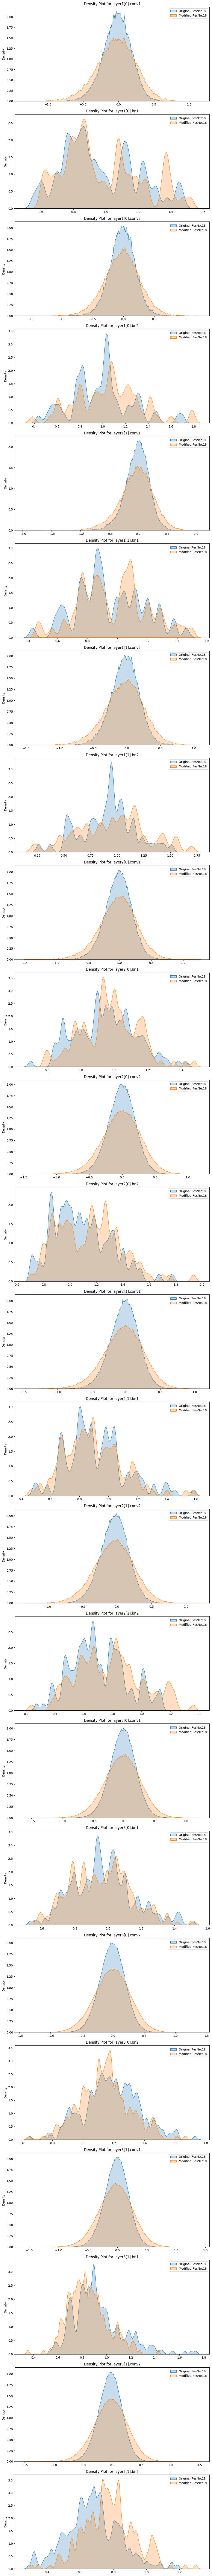

In [ ]:
# Function to extract weights from the first three blocks of ResNet18
def extract_weights(model):
    weights = []
    layer_names = []
    # Layers in the first three blocks
    layers = [
        (model.layer1[0].conv1, 'layer1[0].conv1'), (model.layer1[0].bn1, 'layer1[0].bn1'), (model.layer1[0].conv2, 'layer1[0].conv2'), (model.layer1[0].bn2, 'layer1[0].bn2'),
        (model.layer1[1].conv1, 'layer1[1].conv1'), (model.layer1[1].bn1, 'layer1[1].bn1'), (model.layer1[1].conv2, 'layer1[1].conv2'), (model.layer1[1].bn2, 'layer1[1].bn2'),
        (model.layer2[0].conv1, 'layer2[0].conv1'), (model.layer2[0].bn1, 'layer2[0].bn1'), (model.layer2[0].conv2, 'layer2[0].conv2'), (model.layer2[0].bn2, 'layer2[0].bn2'),
        (model.layer2[1].conv1, 'layer2[1].conv1'), (model.layer2[1].bn1, 'layer2[1].bn1'), (model.layer2[1].conv2, 'layer2[1].conv2'), (model.layer2[1].bn2, 'layer2[1].bn2'),
        (model.layer3[0].conv1, 'layer3[0].conv1'), (model.layer3[0].bn1, 'layer3[0].bn1'), (model.layer3[0].conv2, 'layer3[0].conv2'), (model.layer3[0].bn2, 'layer3[0].bn2'),
        (model.layer3[1].conv1, 'layer3[1].conv1'), (model.layer3[1].bn1, 'layer3[1].bn1'), (model.layer3[1].conv2, 'layer3[1].conv2'), (model.layer3[1].bn2, 'layer3[1].bn2'),
    ]

    for layer, name in layers:
        layer_weights = layer.weight.data.cpu().numpy().flatten()
        weights.append(layer_weights)
        layer_names.append(name)
    return weights, layer_names

# Function to plot density curves for the weights of the first three blocks of two models
def plot_density_curves(weights_model1, weights_model2, layer_names, model1_name='Model 1', model2_name='Model 2'):
    fig, axes = plt.subplots(len(weights_model1), 1, figsize=(10, len(weights_model1) * 5))
    for i in range(len(weights_model1)):
        sns.kdeplot(weights_model1[i], ax=axes[i], label=f'{model1_name}', fill=True, bw_adjust=0.2)
        sns.kdeplot(weights_model2[i], ax=axes[i], label=f'{model2_name}', fill=True, bw_adjust=0.2)
        axes[i].set_title(f'Density Plot for {layer_names[i]}')
        axes[i].legend()

    plt.tight_layout()
    plt.show()

# Main function to extract weights and plot density curves for both models
def plot_comparative_density_curves(model1, model2, model1_name='Model 1', model2_name='Model 2'):
    # Extract weights
    weights_model1, layer_names = extract_weights(model1)
    weights_model2, _ = extract_weights(model2)

    # Plot density curves
    plot_density_curves(weights_model1, weights_model2, layer_names, model1_name, model2_name)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model1 = model.to(device)
model2 = model_hybrid2.resnet.to(device)

# Plot density curves for both models
plot_comparative_density_curves(model1, model2, model1_name='Original ResNet18', model2_name='Modified ResNet18')


**HISTOGRAM OF THE WEIGHTS FOR THE 2 MODELS**

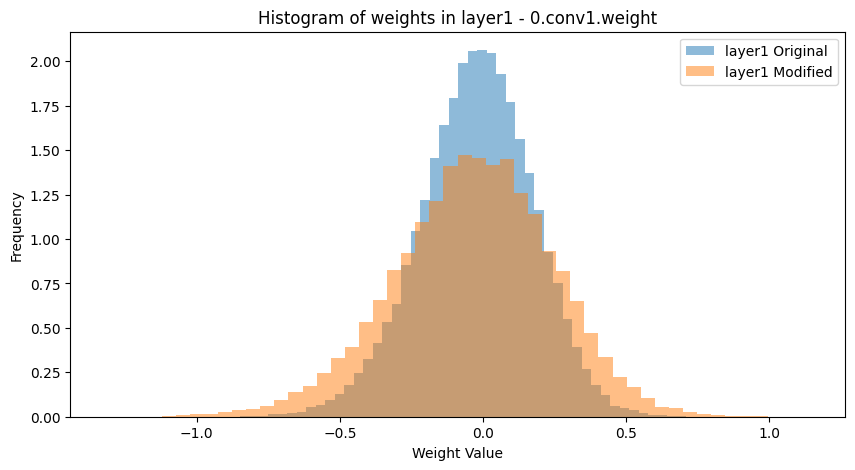

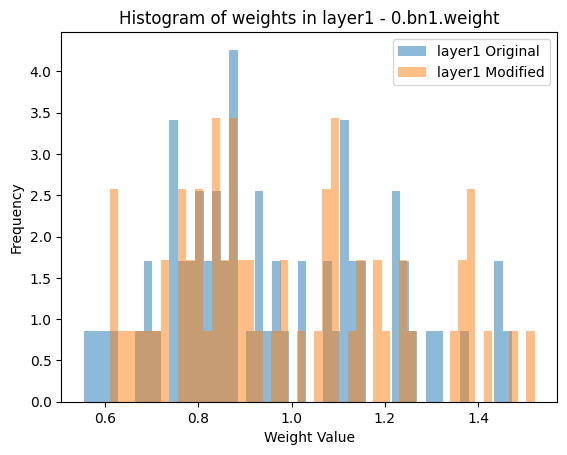

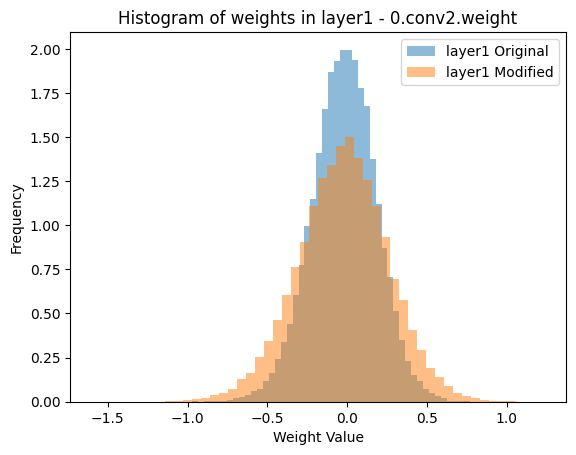

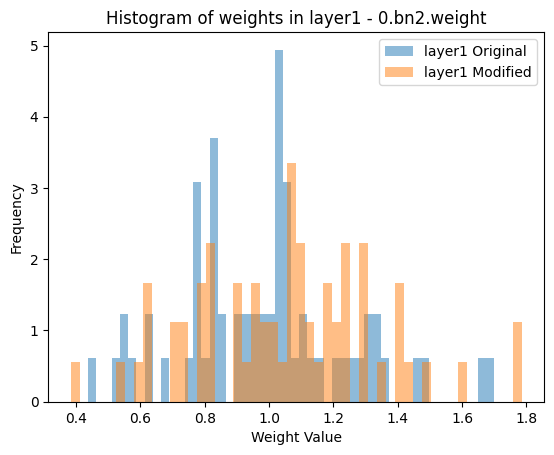

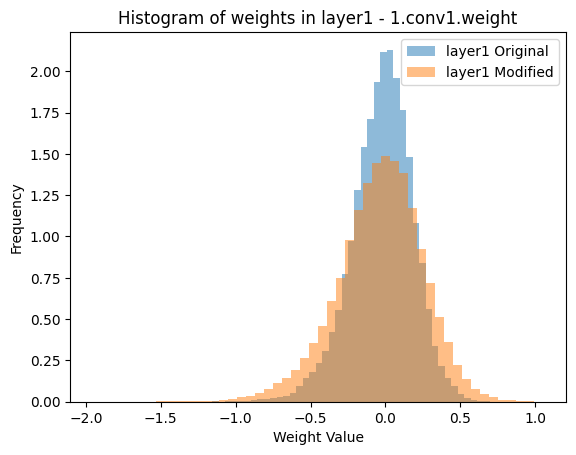

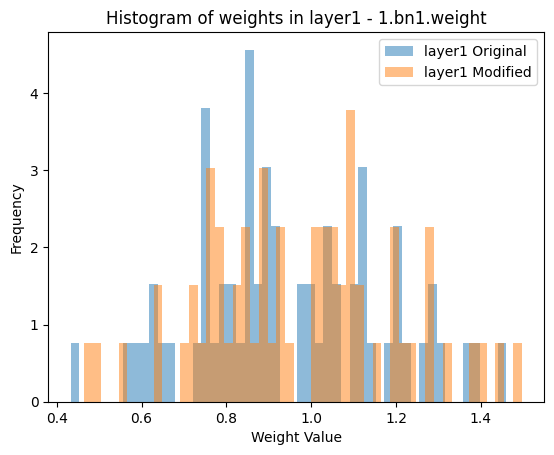

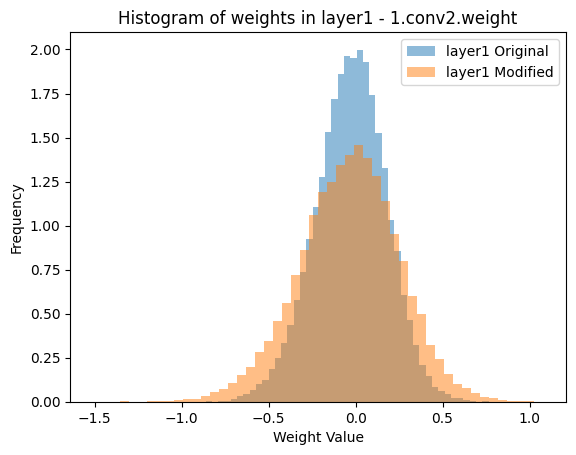

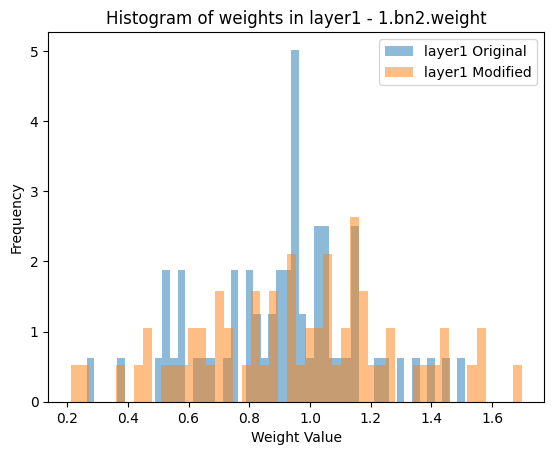

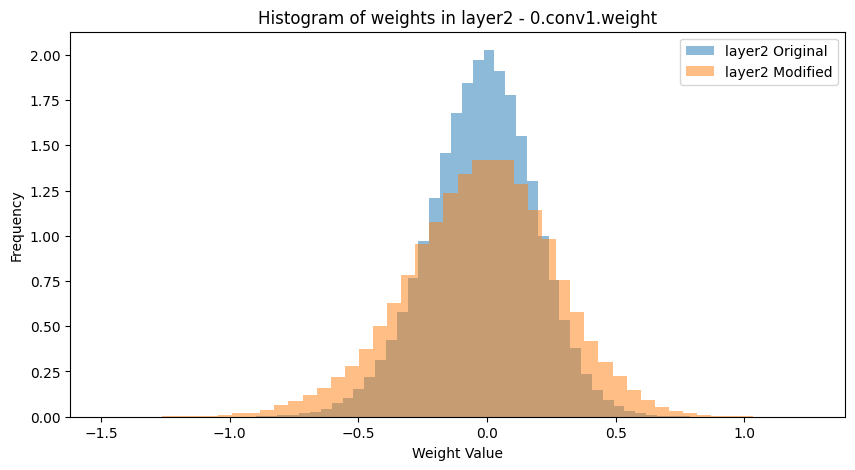

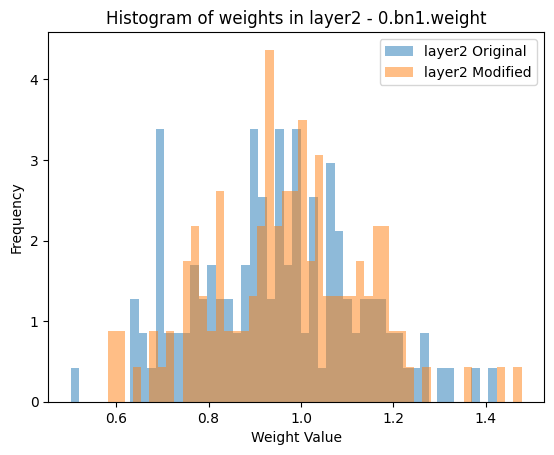

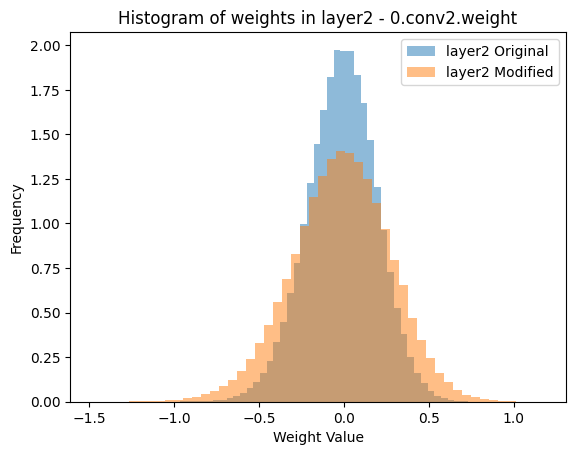

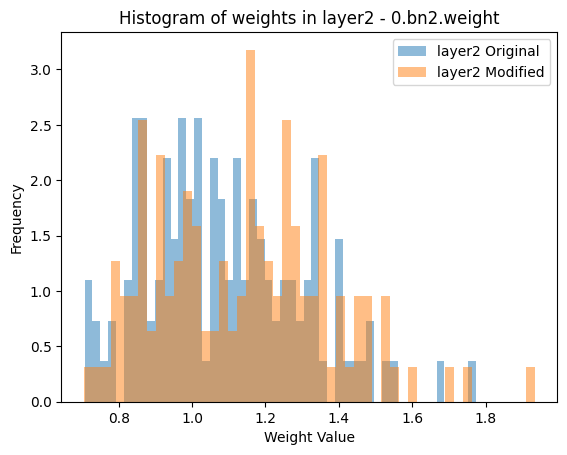

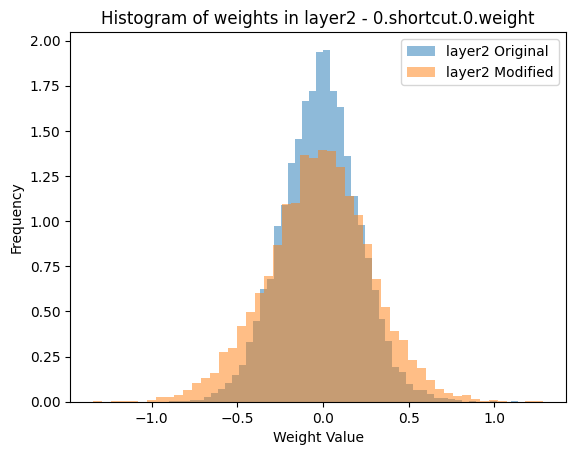

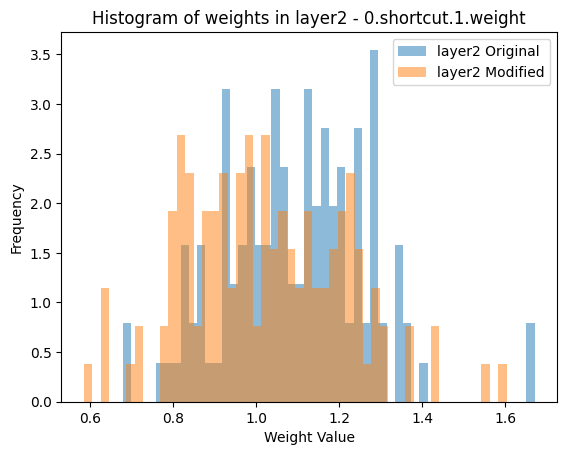

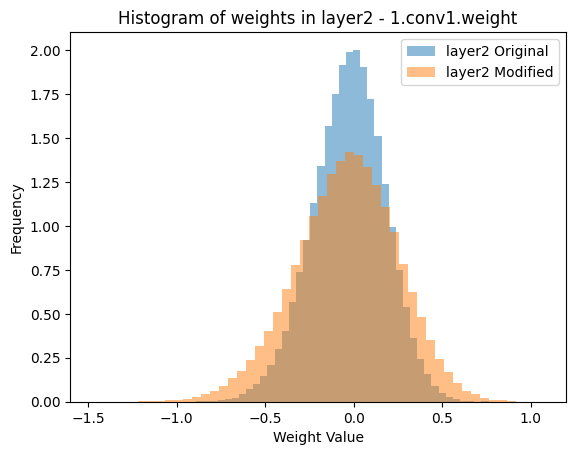

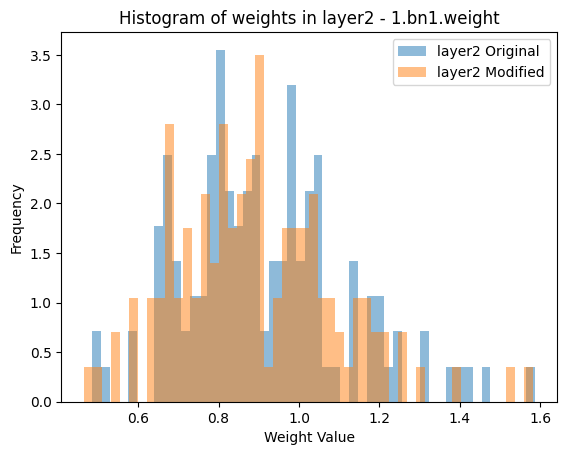

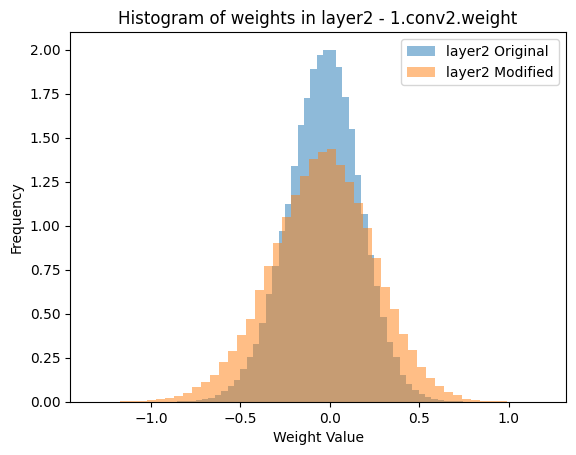

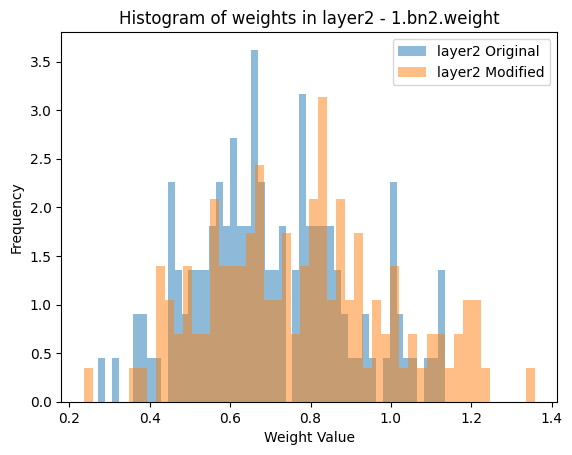

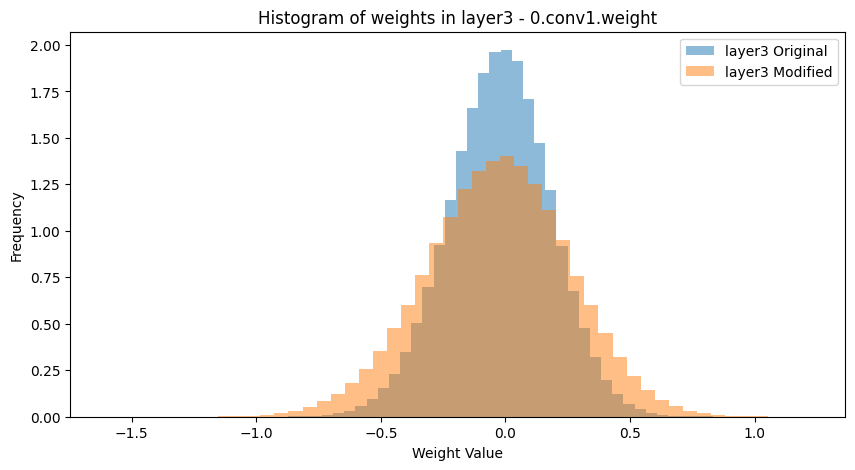

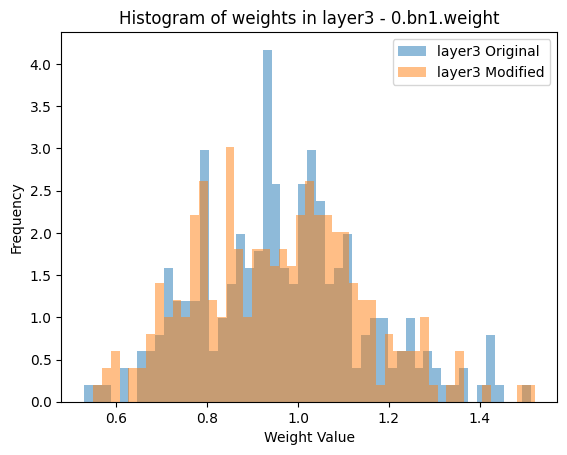

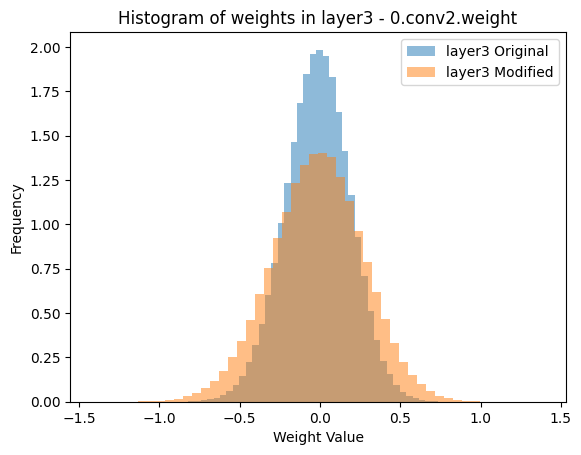

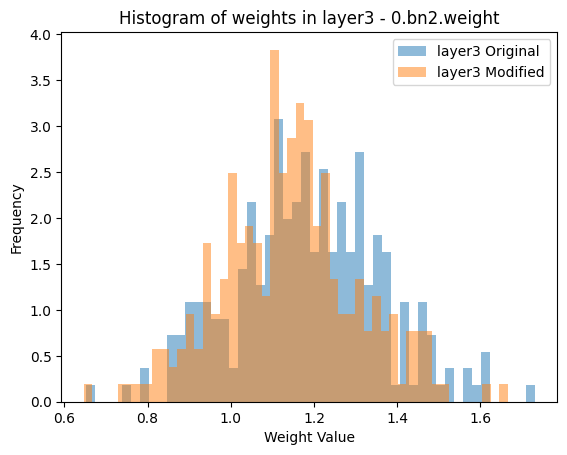

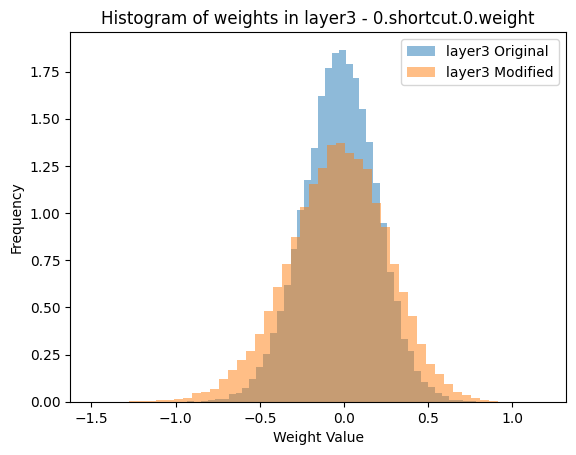

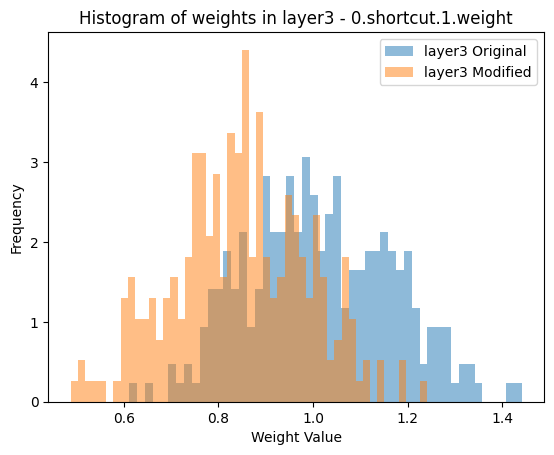

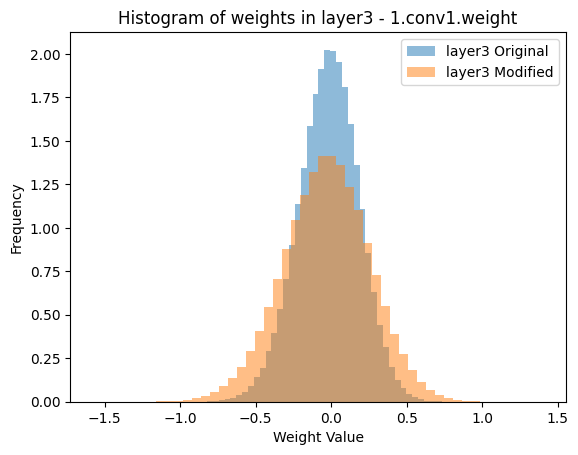

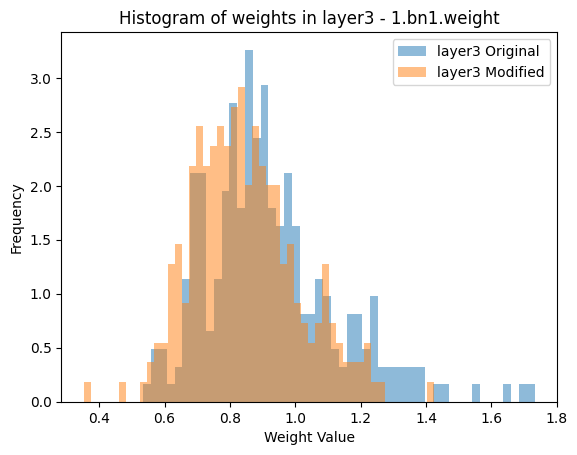

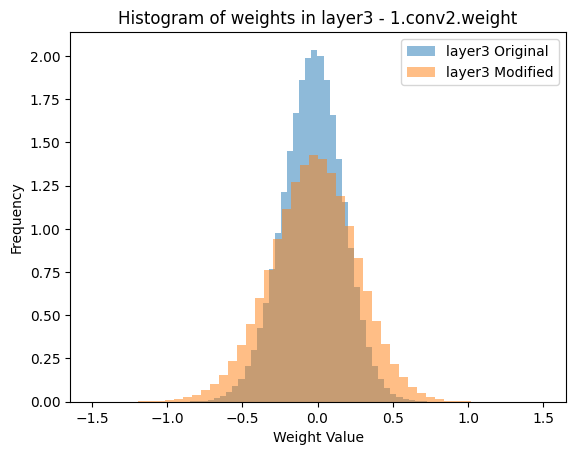

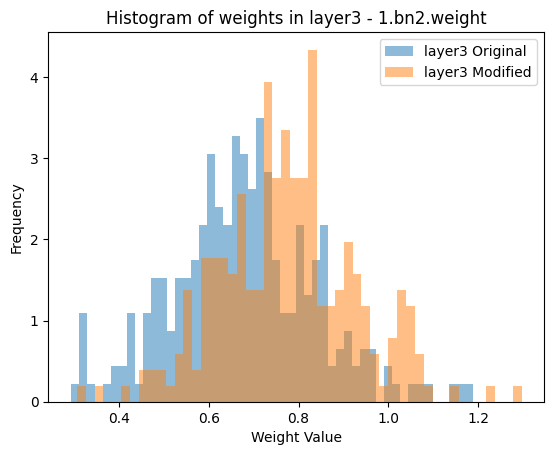

In [ ]:
def plot_histograms(model1, model2, layer_name):
    weights1 = getattr(model1, layer_name).state_dict()
    weights2 = getattr(model2, layer_name).state_dict()

    # Plotting
    plt.figure(figsize=(10, 5))
    for key in weights1.keys():
        if 'weight' in key:  # filters weights to be used for plotting
            plt.hist(weights1[key].cpu().numpy().flatten(), bins=50, alpha=0.5, label=f'{layer_name} Original', density = True)
            plt.hist(weights2[key].cpu().numpy().flatten(), bins=50, alpha=0.5, label=f'{layer_name} Modified', density = True)
            plt.title(f'Histogram of weights in {layer_name} - {key}')
            plt.xlabel('Weight Value')
            plt.ylabel('Pdf')
            plt.legend()
            plt.show()

plot_histograms(model, model_hybrid2.resnet, 'layer1')
plot_histograms(model, model_hybrid2.resnet, 'layer2')
plot_histograms(model, model_hybrid2.resnet, 'layer3')



**PLOTTING QQ-PLOT AND SCATTERPLOT FOR THE WEIGHTS**

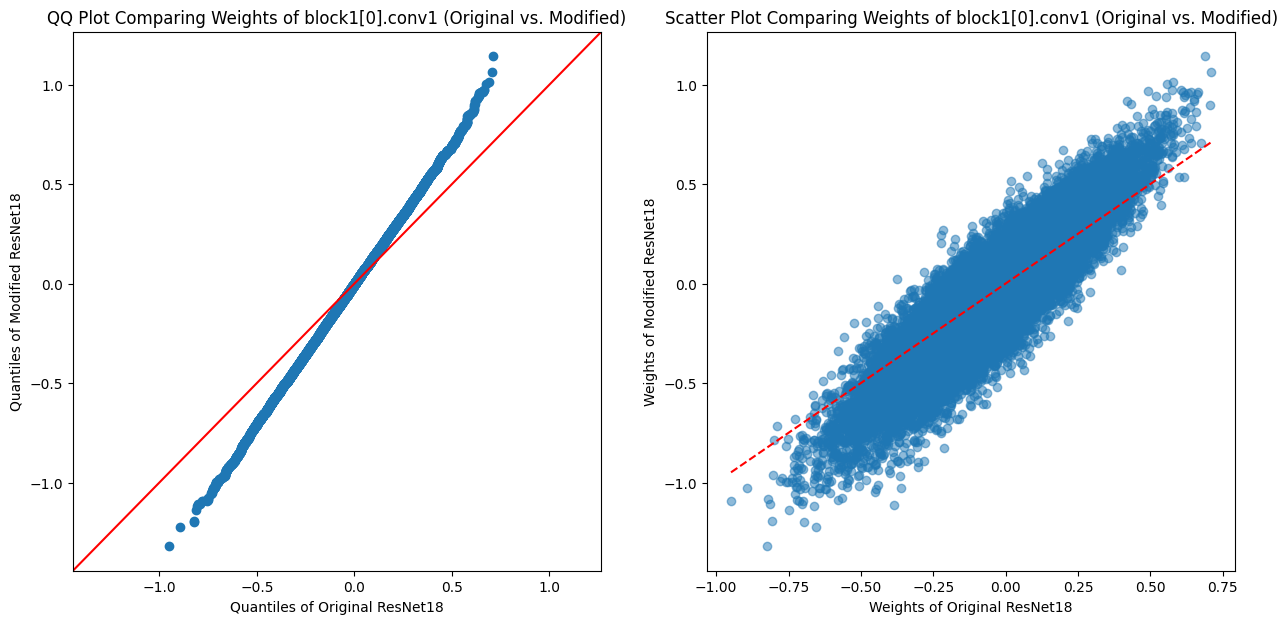

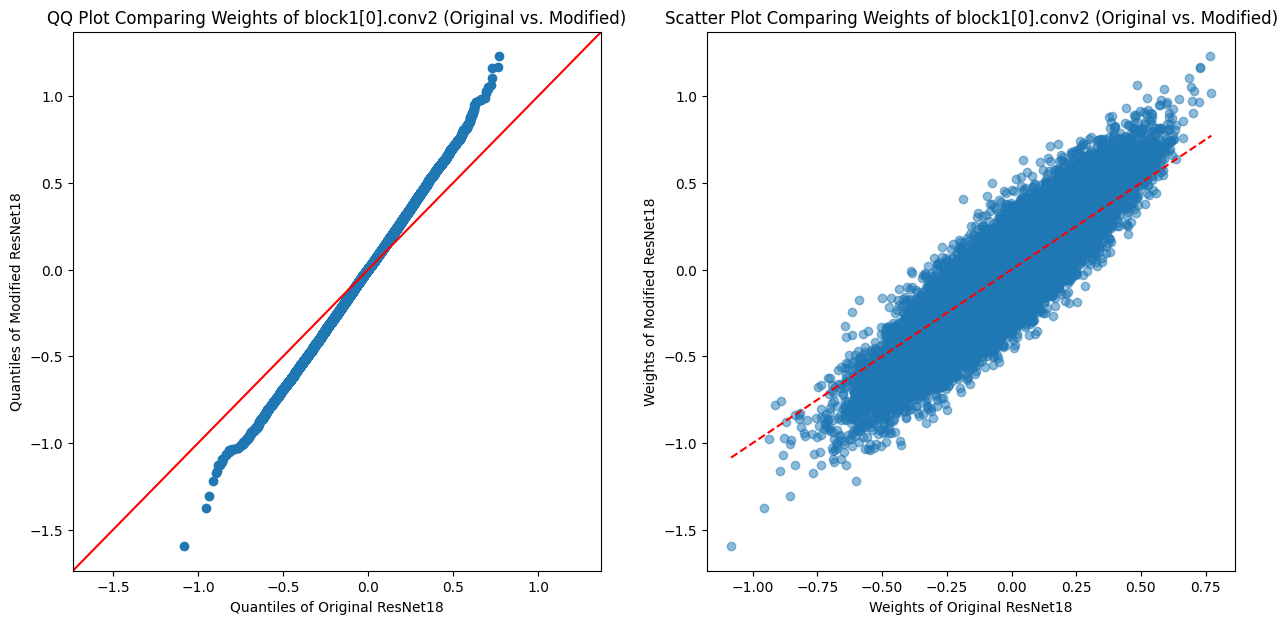

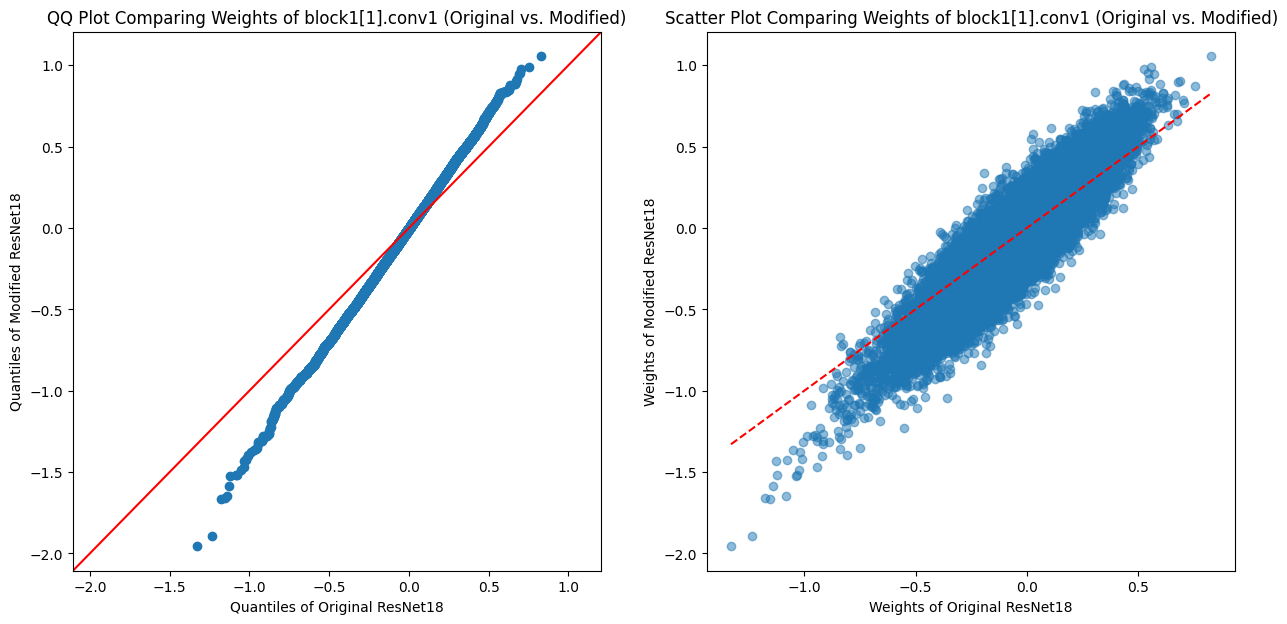

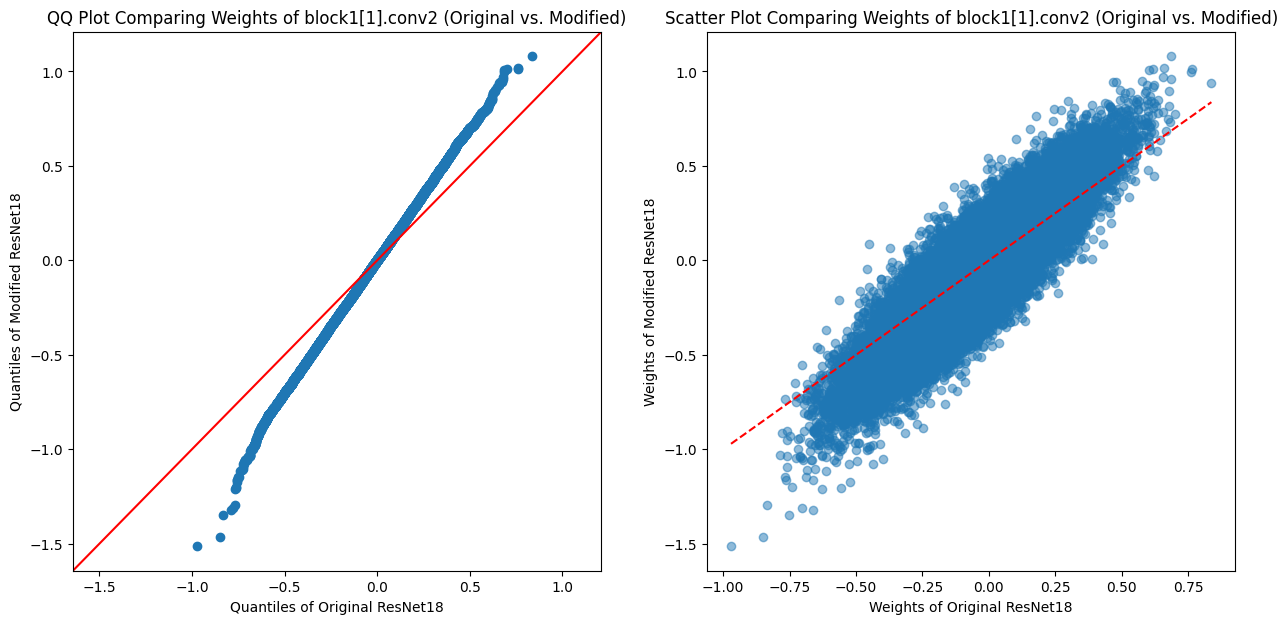

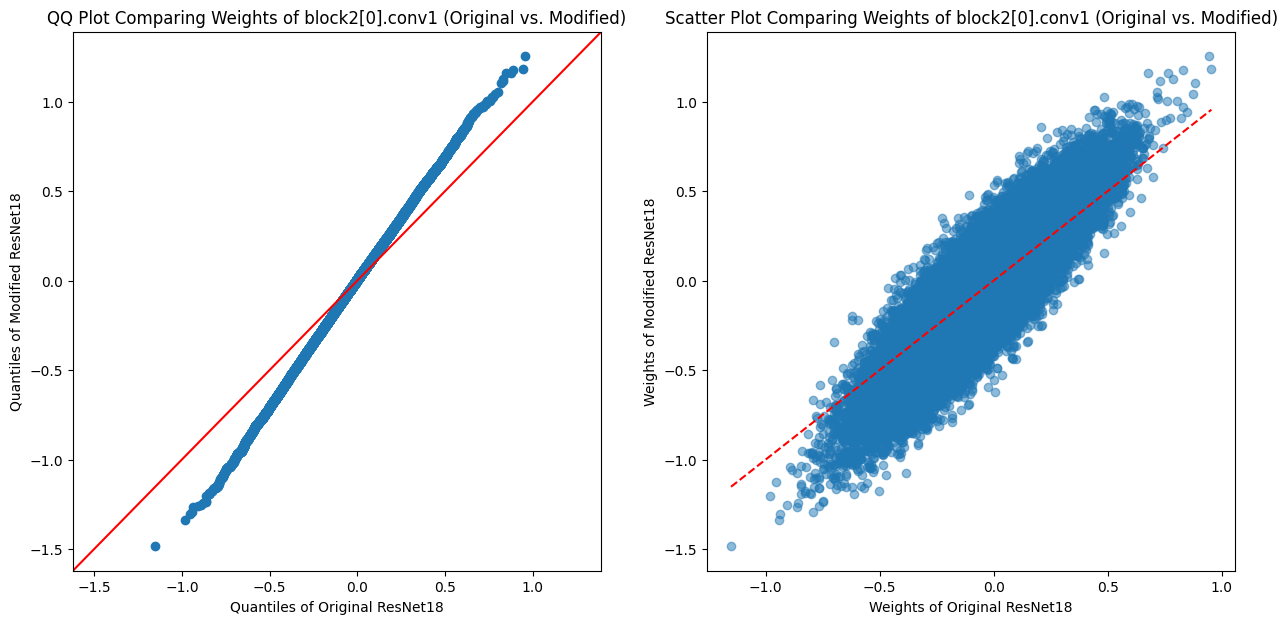

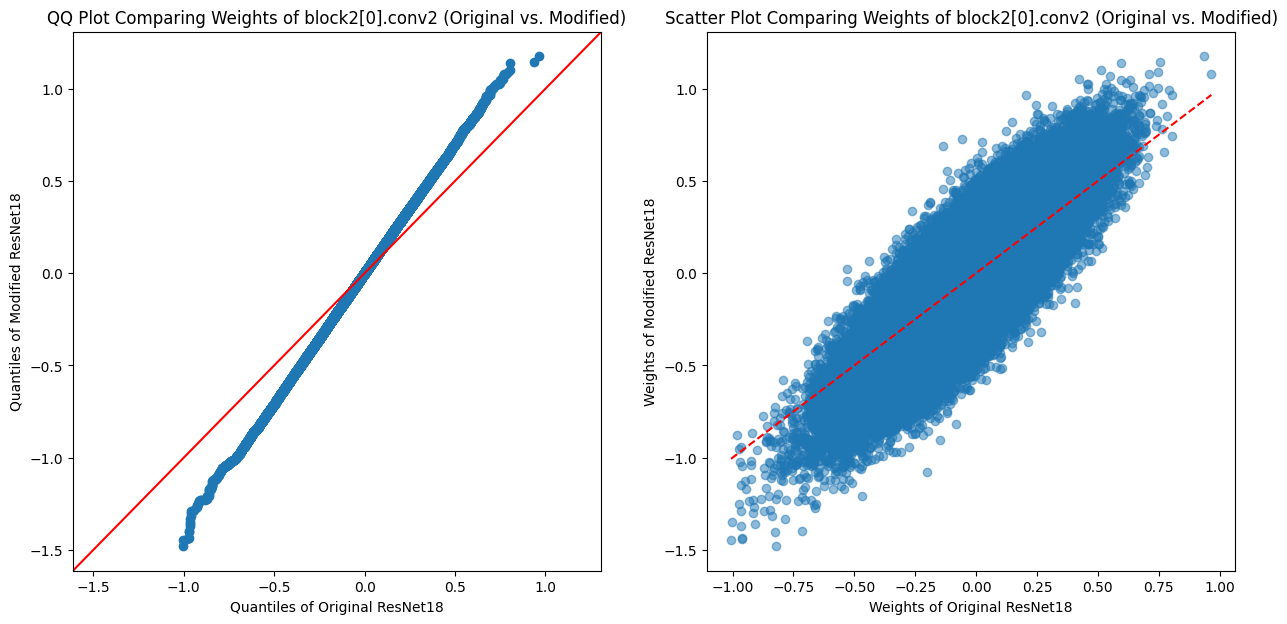

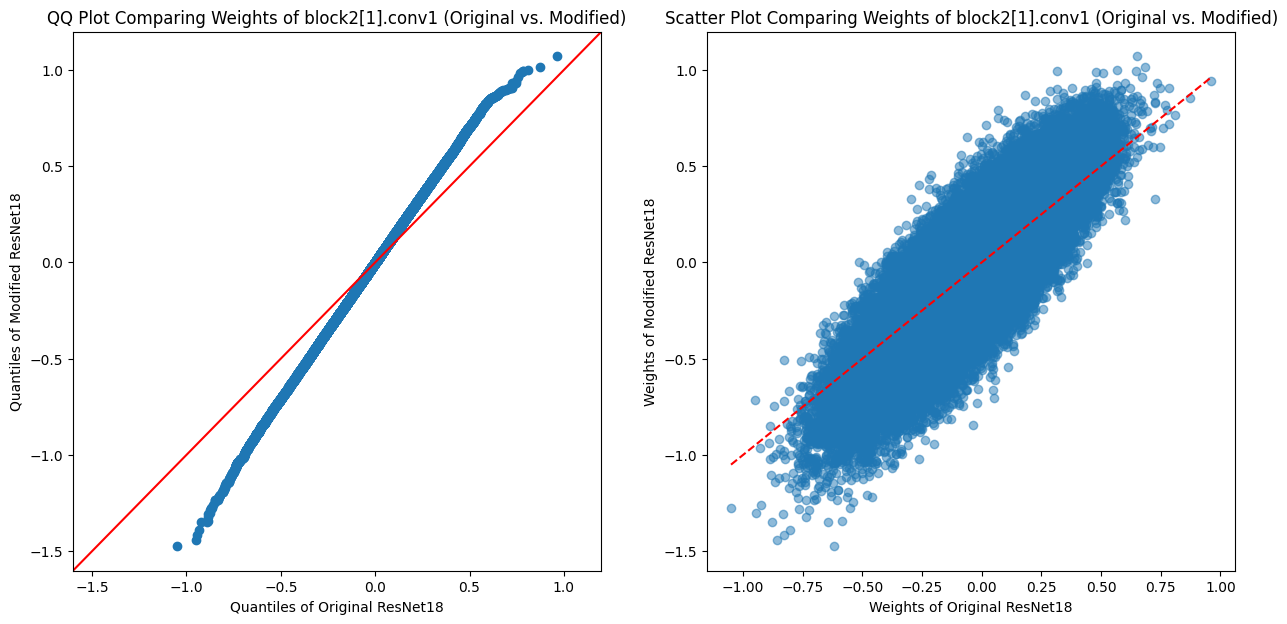

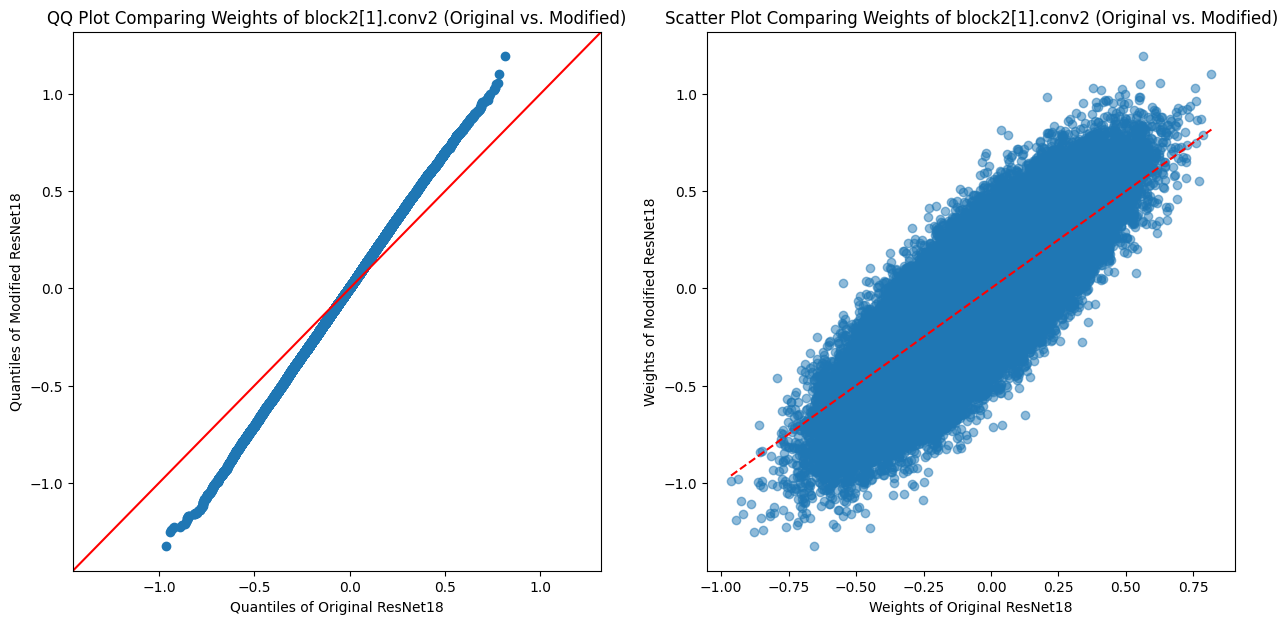

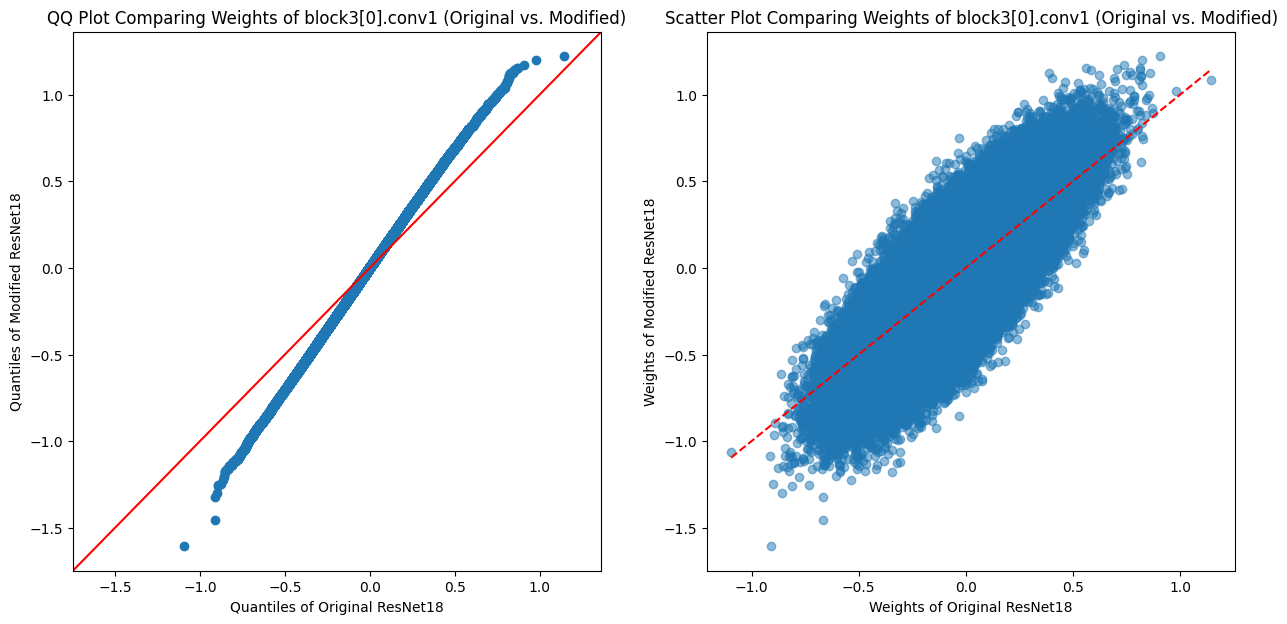

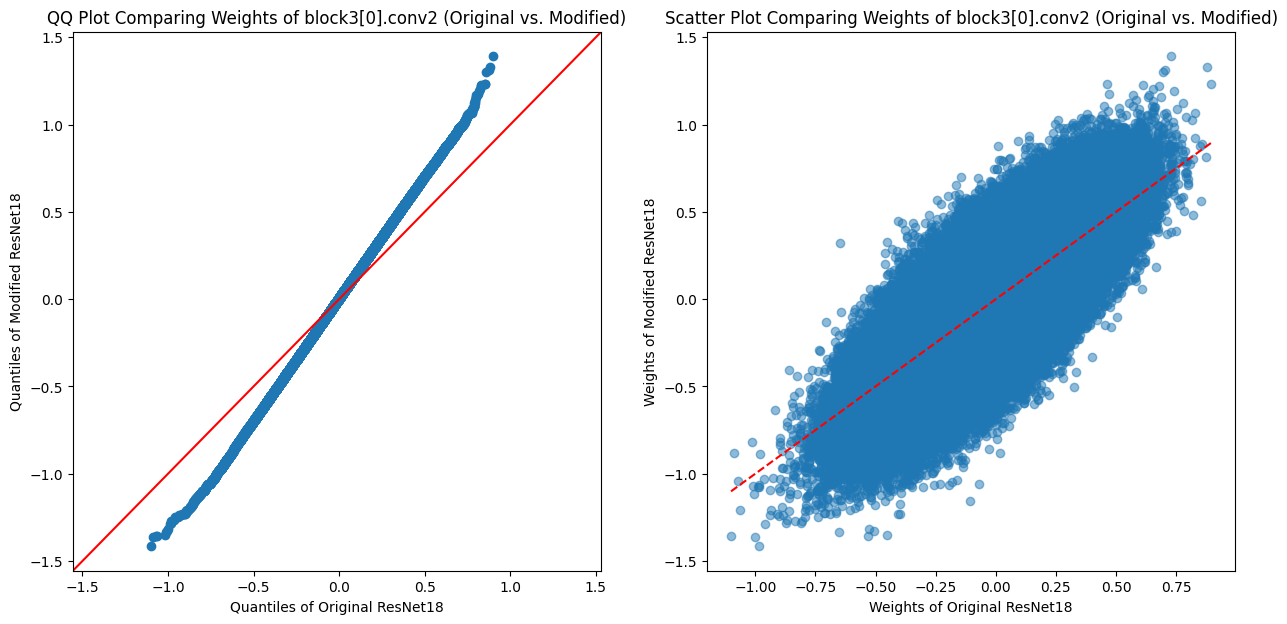

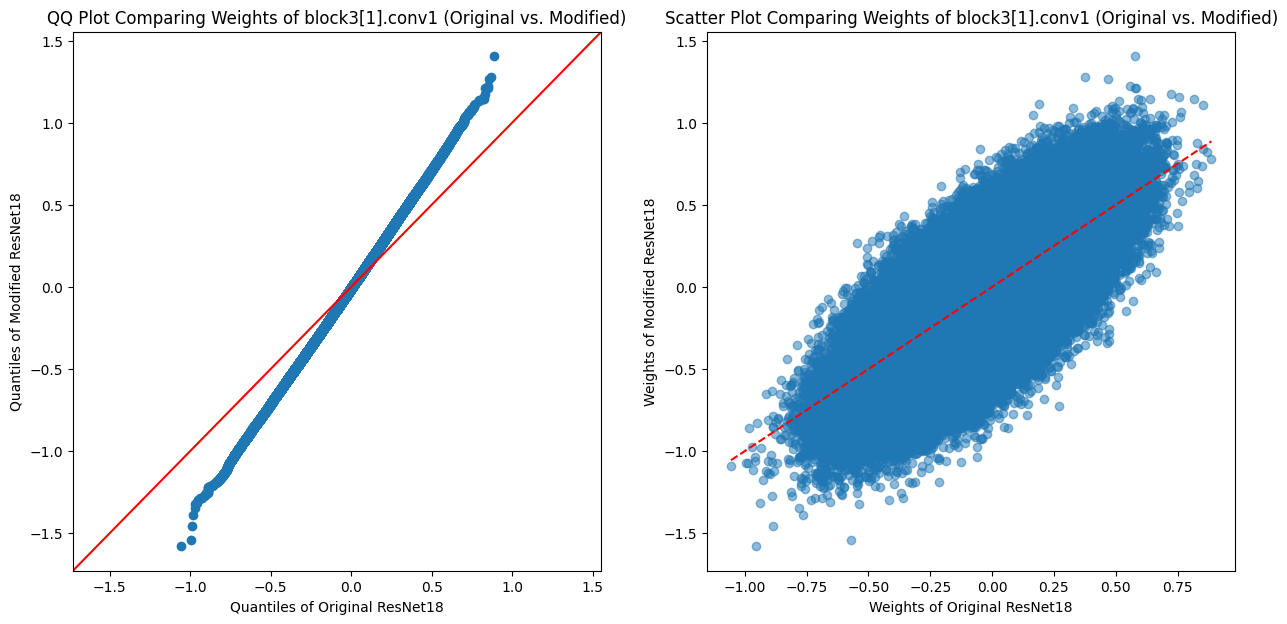

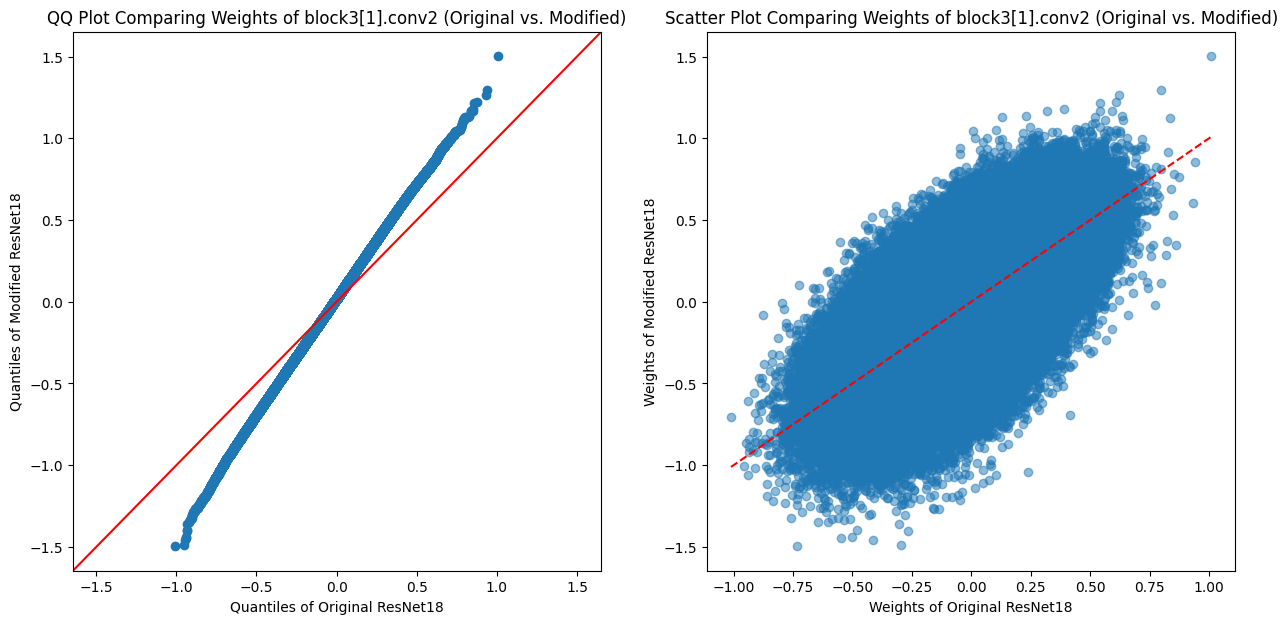

In [ ]:
# Function to extract weights from specific layers
def extract_block_weights(model, blocks):
    weights = []
    for layer in blocks:
        layer_weights = layer.weight.data.cpu().numpy().flatten()
        weights.append(layer_weights)
    return weights

blocks_original = [
    [model.layer1[0].conv1, model.layer1[0].conv2],
    [model.layer1[1].conv1, model.layer1[1].conv2],
    [model.layer2[0].conv1, model.layer2[0].conv2],
    [model.layer2[1].conv1, model.layer2[1].conv2],
    [model.layer3[0].conv1, model.layer3[0].conv2],
    [model.layer3[1].conv1, model.layer3[1].conv2]
]

blocks_modified = [
    [model_hybrid2.resnet.layer1[0].conv1, model_hybrid2.resnet.layer1[0].conv2],
    [model_hybrid2.resnet.layer1[1].conv1, model_hybrid2.resnet.layer1[1].conv2],
    [model_hybrid2.resnet.layer2[0].conv1, model_hybrid2.resnet.layer2[0].conv2],
    [model_hybrid2.resnet.layer2[1].conv1, model_hybrid2.resnet.layer2[1].conv2],
    [model_hybrid2.resnet.layer3[0].conv1, model_hybrid2.resnet.layer3[0].conv2],
    [model_hybrid2.resnet.layer3[1].conv1, model_hybrid2.resnet.layer3[1].conv2]
]

blocks = [
    'block1[0].conv1', 'block1[0].conv2', 'block1[1].conv1','block1[1].conv2',
    'block2[0].conv1', 'block2[0].conv2', 'block2[1].conv1', 'block2[1].conv2',
    'block3[0].conv1', 'block3[0].conv2', 'block3[1].conv1', 'block3[1].conv2'
]

# Extract weights for each block
weights_original = extract_block_weights(model, [block for sublist in blocks_original for block in sublist])
weights_modified = extract_block_weights(model_hybrid2.resnet, [block for sublist in blocks_modified for block in sublist])

# Comparing each block with QQ plots and scatter plots
for i in range(len(weights_original)):
    fig, axs = plt.subplots(1, 2, figsize=(15, 7))

    # QQ Plot
    sm.qqplot_2samples(weights_original[i], weights_modified[i], line='45', ax=axs[0])
    axs[0].set_title(f'QQ Plot Comparing Weights of {blocks[i]} (Original vs. Modified)')
    axs[0].set_xlabel('Quantiles of Original ResNet18')
    axs[0].set_ylabel('Quantiles of Modified ResNet18')

    # Scatter Plot
    axs[1].scatter(weights_original[i], weights_modified[i], alpha=0.5)
    axs[1].plot([min(weights_original[i]), max(weights_original[i])], [min(weights_original[i]), max(weights_original[i])], 'r--')
    axs[1].set_title(f'Scatter Plot Comparing Weights of {blocks[i]} (Original vs. Modified)')
    axs[1].set_xlabel('Weights of Original ResNet18')
    axs[1].set_ylabel('Weights of Modified ResNet18')

    plt.show()


**ANALYSIS ON ACCURACIES:**

1. **MAKING CONFUSION MATRIX**
2. **CLASS-WISE ACCURACY USING BOOTSTRAP METHOD**
3. **MAKING 95% CI**
4. **DISTRIBUTION OF ACCURACIES CLASS-WISE**



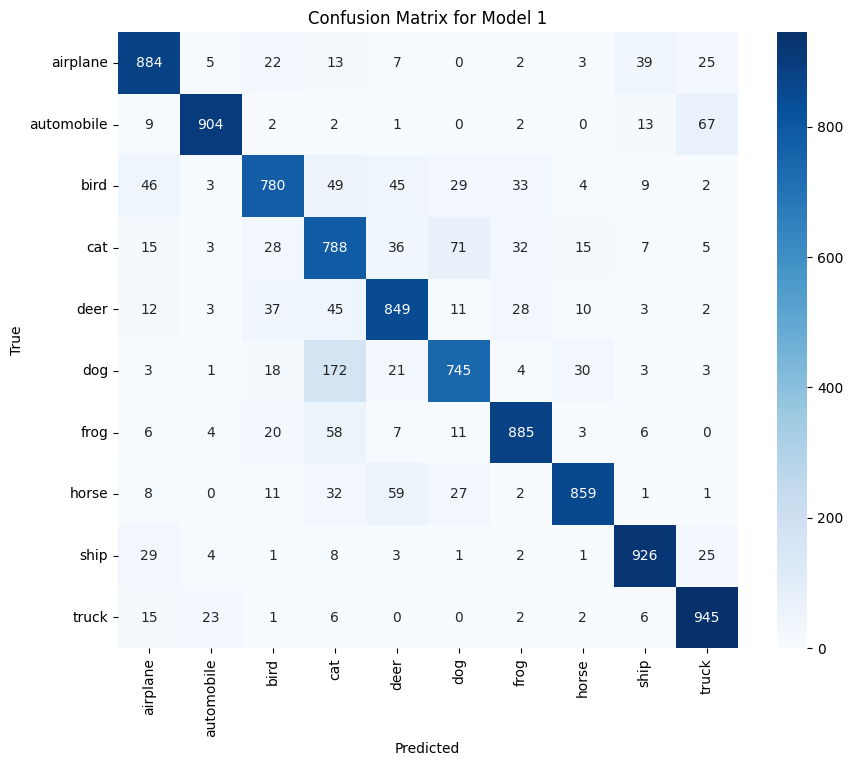

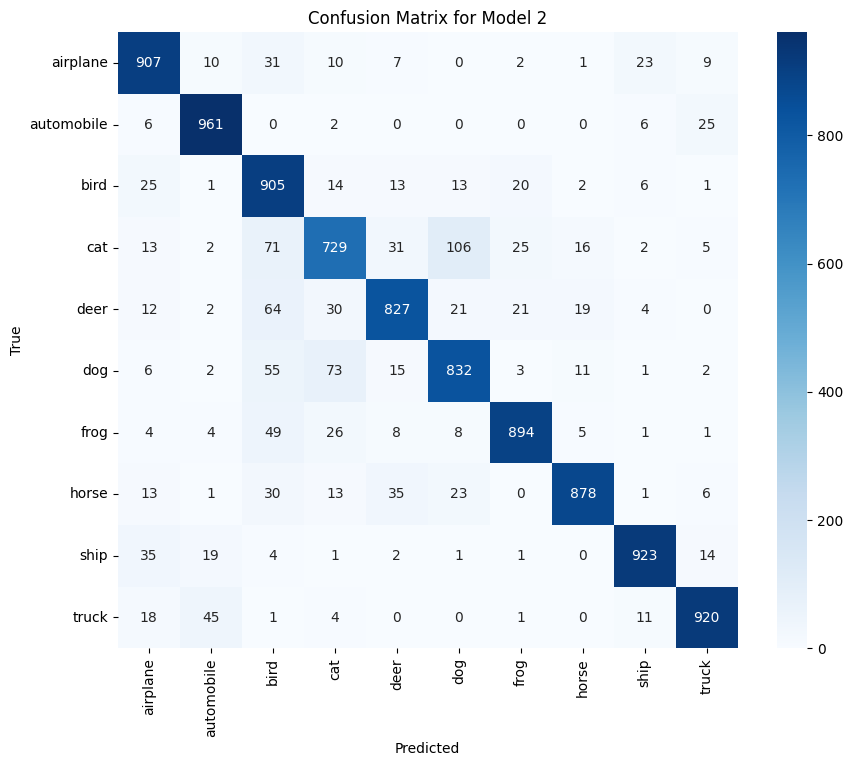

Class airplane: Model 1 Accuracy 95% CI = (0.8640, 0.9030), Model 2 Accuracy 95% CI = (0.8880, 0.9250)
Difference in accuracy for class airplane is NOT SIGNIFICANT.

Class automobile: Model 1 Accuracy 95% CI = (0.8860, 0.9230), Model 2 Accuracy 95% CI = (0.9490, 0.9720)
Difference in accuracy for class automobile is SIGNIFICANT.

Class bird: Model 1 Accuracy 95% CI = (0.7540, 0.8040), Model 2 Accuracy 95% CI = (0.8870, 0.9230)
Difference in accuracy for class bird is SIGNIFICANT.

Class cat: Model 1 Accuracy 95% CI = (0.7620, 0.8130), Model 2 Accuracy 95% CI = (0.7010, 0.7580)
Difference in accuracy for class cat is SIGNIFICANT.

Class deer: Model 1 Accuracy 95% CI = (0.8280, 0.8710), Model 2 Accuracy 95% CI = (0.8040, 0.8500)
Difference in accuracy for class deer is NOT SIGNIFICANT.

Class dog: Model 1 Accuracy 95% CI = (0.7150, 0.7710), Model 2 Accuracy 95% CI = (0.8090, 0.8530)
Difference in accuracy for class dog is SIGNIFICANT.

Class frog: Model 1 Accuracy 95% CI = (0.8640, 0.905

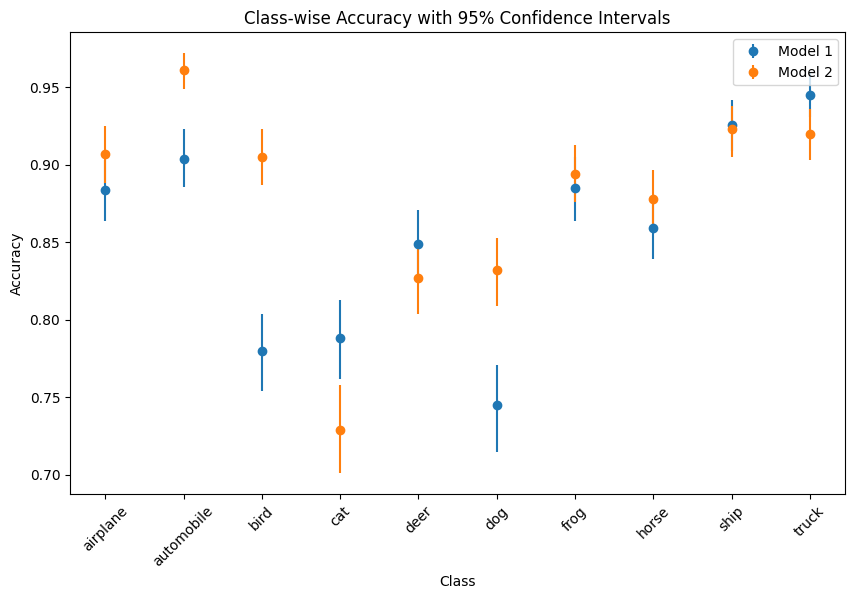

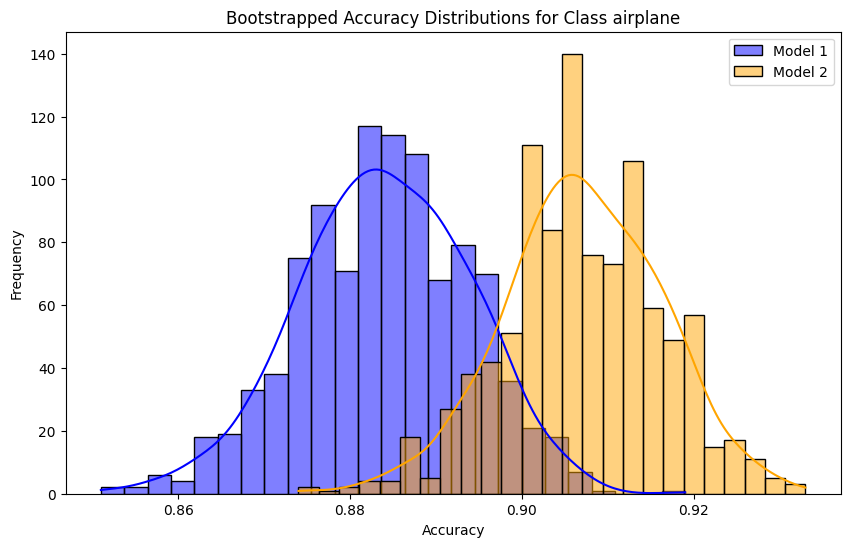

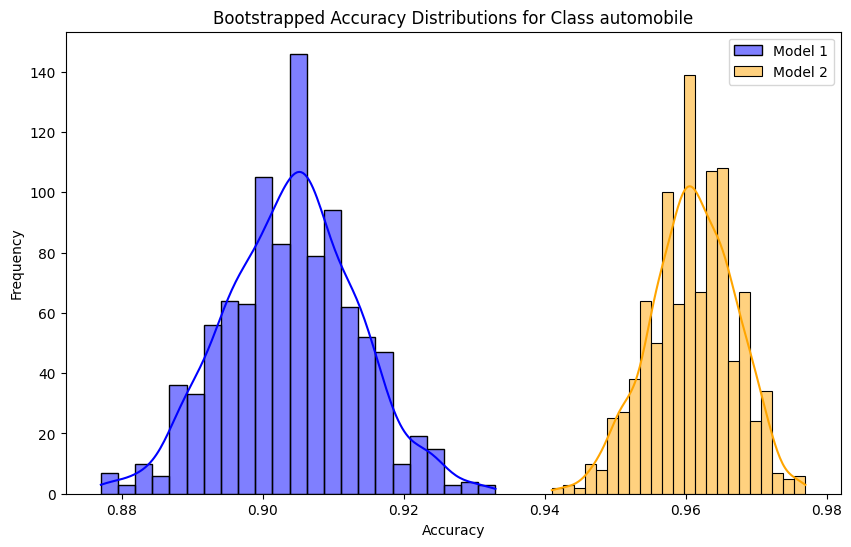

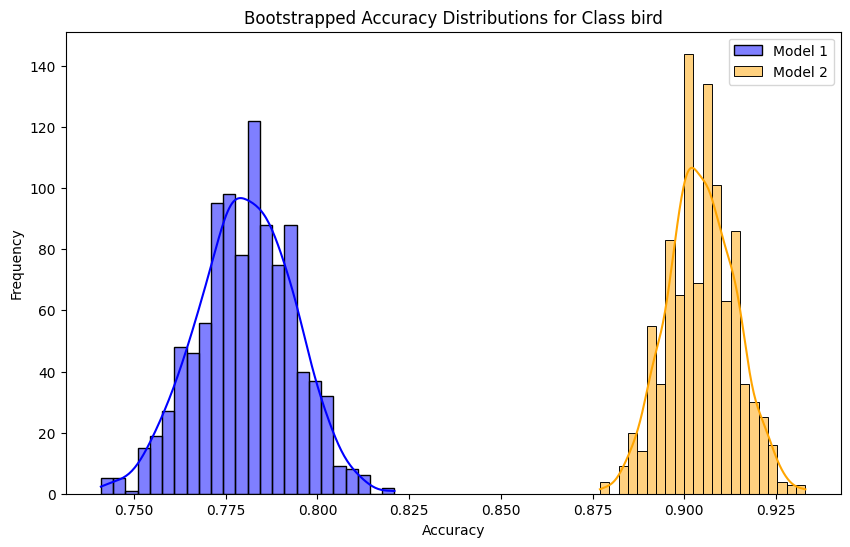

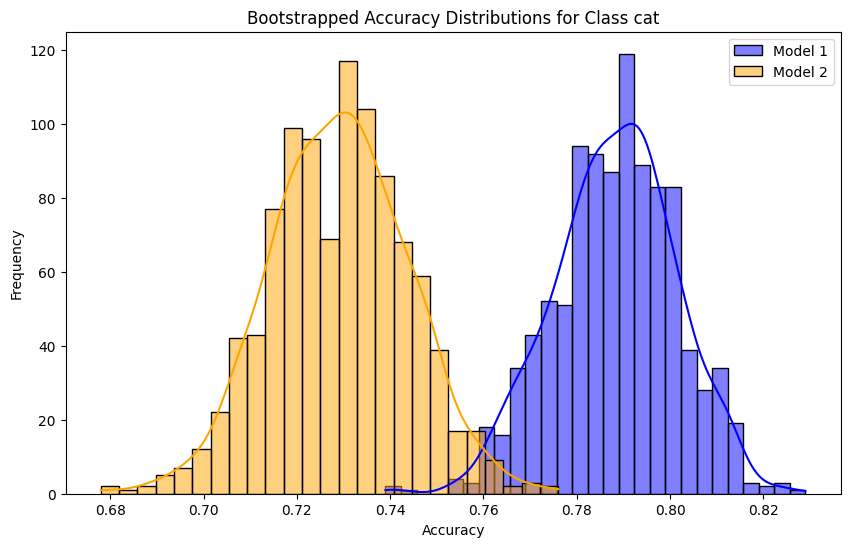

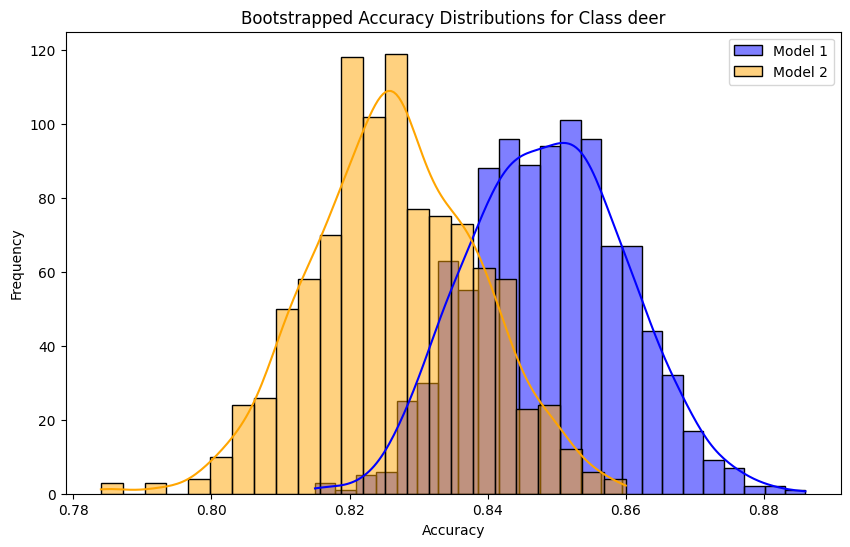

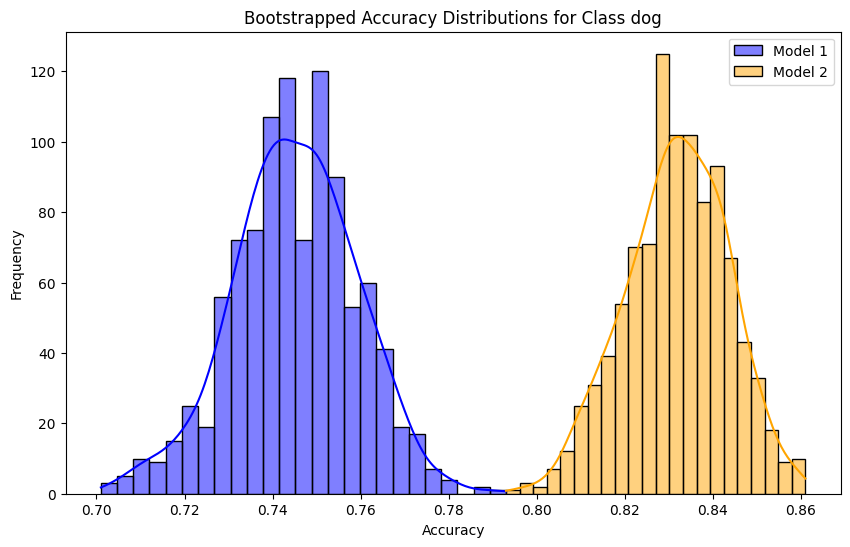

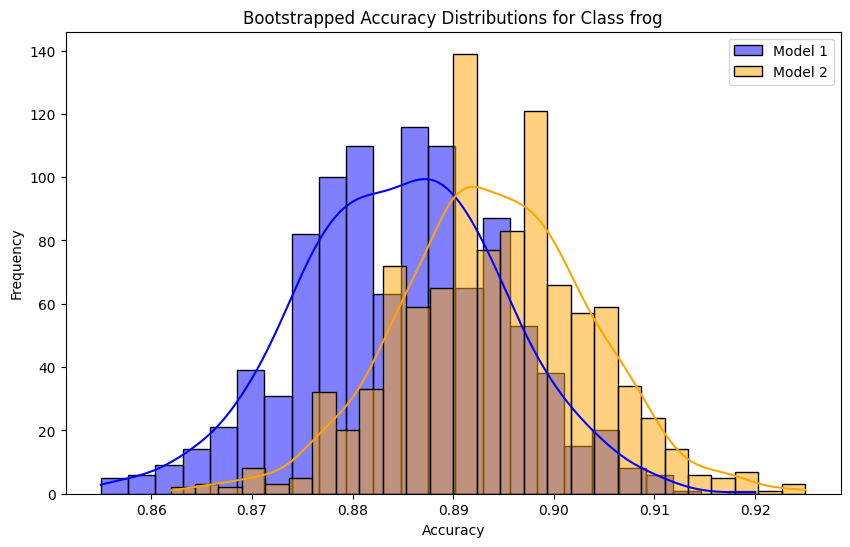

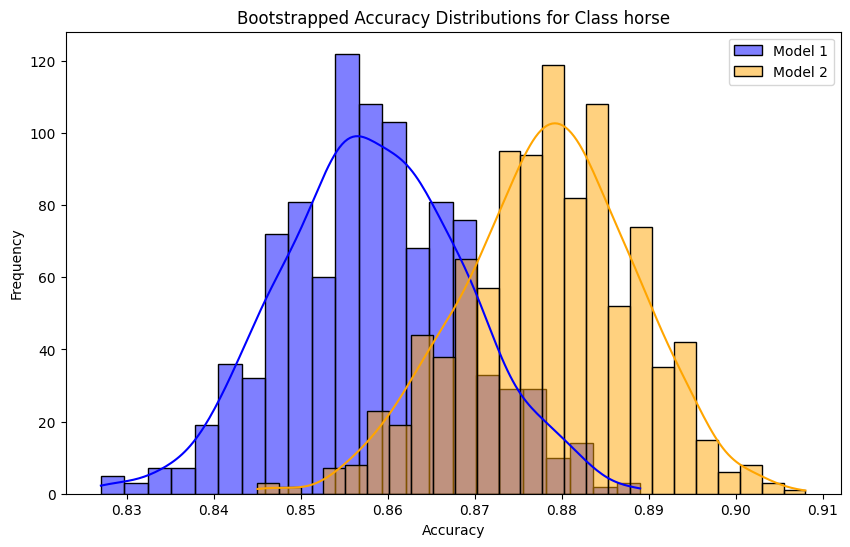

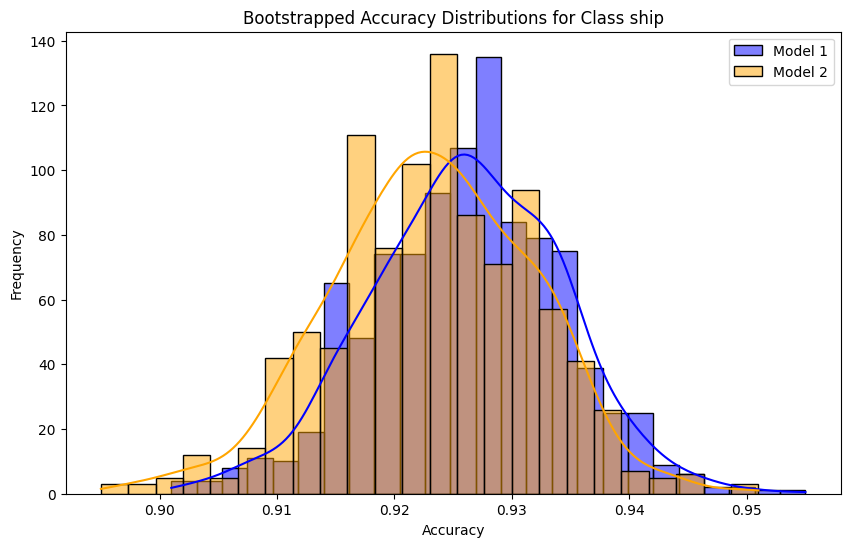

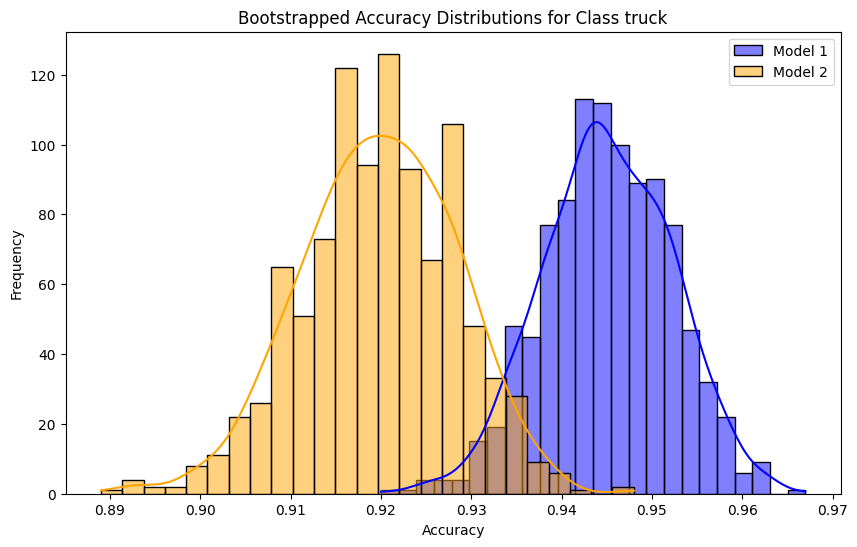

Significant Classes with p-values and test statistics:


KeyError: 'airplane'

In [ ]:
############################### MAKE CONFUSION MATRIX ##########################################


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model1 = model.to(device)
model2 = model_hybrid2.to(device)



# Function to evaluate the model and collect predictions
def evaluate_model(model, data_loader):
    model.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    return np.array(all_labels), np.array(all_predictions)


# Evaluate both models
labels_model1, predictions_model1 = evaluate_model(model1, test_loader)
labels_model2, predictions_model2 = evaluate_model(model2, test_loader)

# Compute confusion matrices
conf_matrix_model1 = confusion_matrix(labels_model1, predictions_model1)
conf_matrix_model2 = confusion_matrix(labels_model2, predictions_model2)

# Function to plot confusion matrix
def plot_confusion_matrix(conf_matrix, title):
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()

# Plotting confusion matrices
plot_confusion_matrix(conf_matrix_model1, 'Confusion Matrix for Model 1')
plot_confusion_matrix(conf_matrix_model2, 'Confusion Matrix for Model 2')



############################################### CLASS-WISE ACCURACY AND 95% CI ######################################################

# Function to calculate class-wise accuracy
def class_accuracies(conf_matrix):
    return conf_matrix.diagonal() / conf_matrix.sum(axis=1)

acc1 = class_accuracies(conf_matrix_model1)
acc2 = class_accuracies(conf_matrix_model2)

# Bootstrapping to find confidence intervals and distributions
n_bootstraps = 1000
rng = np.random.default_rng()

def bootstrap_confidence_intervals_and_distributions(labels, predictions, n_classes, n_bootstraps=1000, alpha=0.05):
    bootstrapped_means = np.zeros((n_classes, n_bootstraps))
    for cls in range(n_classes):
        cls_indices = (labels == cls)
        correct_preds = predictions[cls_indices] == labels[cls_indices]
        for i in range(n_bootstraps):
            resampled_data = rng.choice(correct_preds, size=len(correct_preds), replace=True)
            bootstrapped_means[cls, i] = np.mean(resampled_data)
    lower_bounds = np.percentile(bootstrapped_means, alpha/2*100, axis=1)
    upper_bounds = np.percentile(bootstrapped_means, (1-alpha/2)*100, axis=1)
    return lower_bounds, upper_bounds, bootstrapped_means

# Calculate confidence intervals and bootstrapped samples for each class accuracy in both models
ci_acc1_lower, ci_acc1_upper, bootstrapped_accuracies_model1 = bootstrap_confidence_intervals_and_distributions(labels_model1, predictions_model1, len(test_dataset.classes))
ci_acc2_lower, ci_acc2_upper, bootstrapped_accuracies_model2 = bootstrap_confidence_intervals_and_distributions(labels_model2, predictions_model2, len(test_dataset.classes))

# results
for i, (acc1_ci_lower, acc1_ci_upper, acc2_ci_lower, acc2_ci_upper) in enumerate(zip(ci_acc1_lower, ci_acc1_upper, ci_acc2_lower, ci_acc2_upper)):
    print(f"Class {test_dataset.classes[i]}: Model 1 Accuracy 95% CI = ({acc1_ci_lower:.4f}, {acc1_ci_upper:.4f}), Model 2 Accuracy 95% CI = ({acc2_ci_lower:.4f}, {acc2_ci_upper:.4f})")
    significant = not (acc1_ci_upper >= acc2_ci_lower and acc2_ci_upper >= acc1_ci_lower)
    significance_str = "SIGNIFICANT" if significant else "NOT SIGNIFICANT"
    print(f"Difference in accuracy for class {test_dataset.classes[i]} is {significance_str}.\n")

# Plotting the accuracy and confidence intervals for both models
classes = range(len(test_dataset.classes))
plt.figure(figsize=(10, 6))
plt.errorbar(classes, acc1, yerr=[acc1 - ci_acc1_lower, ci_acc1_upper - acc1], fmt='o', label='Model 1')
plt.errorbar(classes, acc2, yerr=[acc2 - ci_acc2_lower, ci_acc2_upper - acc2], fmt='o', label='Model 2')
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.title('Class-wise Accuracy with 95% Confidence Intervals')
plt.xticks(ticks=classes, labels=test_dataset.classes, rotation=45)
plt.legend()
plt.show()


########################################### DISTRIBUTION OF ACCURACIES  #######################################################################################

# Plotting distributions of bootstrapped accuracies for all classes
for class_idx in range(len(test_dataset.classes)):
    plt.figure(figsize=(10, 6))
    sns.histplot(bootstrapped_accuracies_model1[class_idx], kde=True, label='Model 1', color='blue')
    sns.histplot(bootstrapped_accuracies_model2[class_idx], kde=True, label='Model 2', color='orange')
    plt.xlabel('Accuracy')
    plt.ylabel('Frequency')
    plt.title(f'Bootstrapped Accuracy Distributions for Class {test_dataset.classes[class_idx]}')
    plt.legend()
    plt.show()


**WILCOXON SIGNED RANK TEST**

In [17]:
# Set the seed
random.seed(1)

# define variables to store values
p_values = []
test_statistics = []

# Perform the Wilcoxon Signed-Rank Test for each class
for class_idx in range(len(test_dataset.classes)):
    acc_diff = bootstrapped_accuracies_model1[class_idx] - bootstrapped_accuracies_model2[class_idx]
    non_zero_differences = acc_diff[acc_diff != 0]

    if len(non_zero_differences) > 0:
        stat, p_value = wilcoxon(non_zero_differences, alternative='two-sided')
        test_statistics.append(stat)
        p_values.append(p_value)
    else:
        test_statistics.append(None)
        p_values.append(None)

# Results
print("Wilcoxon Signed-Rank Test Results:")
for class_idx, (stat, p_value) in enumerate(zip(test_statistics, p_values)):
    class_name = test_dataset.classes[class_idx]
    if stat is not None and p_value is not None:
        significance = "SIGNIFICANT" if p_value < 0.05 else "NOT SIGNIFICANT"
        print(f"Class {class_name}: p-value = {p_value:.4f}, test statistic = {stat:.4f} ({significance})")
    else:
        print(f"Class {class_name}: Not enough data for valid test.")


Wilcoxon Signed-Rank Test Results:
Class airplane: p-value = 0.0000, test statistic = 5.5000 (SIGNIFICANT)
Class automobile: p-value = 0.0000, test statistic = 0.0000 (SIGNIFICANT)
Class bird: p-value = 0.0000, test statistic = 0.0000 (SIGNIFICANT)
Class cat: p-value = 0.0000, test statistic = 0.0000 (SIGNIFICANT)
Class deer: p-value = 0.0000, test statistic = 192716.0000 (SIGNIFICANT)
Class dog: p-value = 0.0000, test statistic = 0.0000 (SIGNIFICANT)
Class frog: p-value = 0.0000, test statistic = 12490.5000 (SIGNIFICANT)
Class horse: p-value = 0.0000, test statistic = 7921.0000 (SIGNIFICANT)
Class ship: p-value = 0.0000, test statistic = 151449.5000 (SIGNIFICANT)
Class truck: p-value = 0.0000, test statistic = 14.5000 (SIGNIFICANT)


**TEST STATISTICS FROM WILCOXON SIGNED RANK TEST**

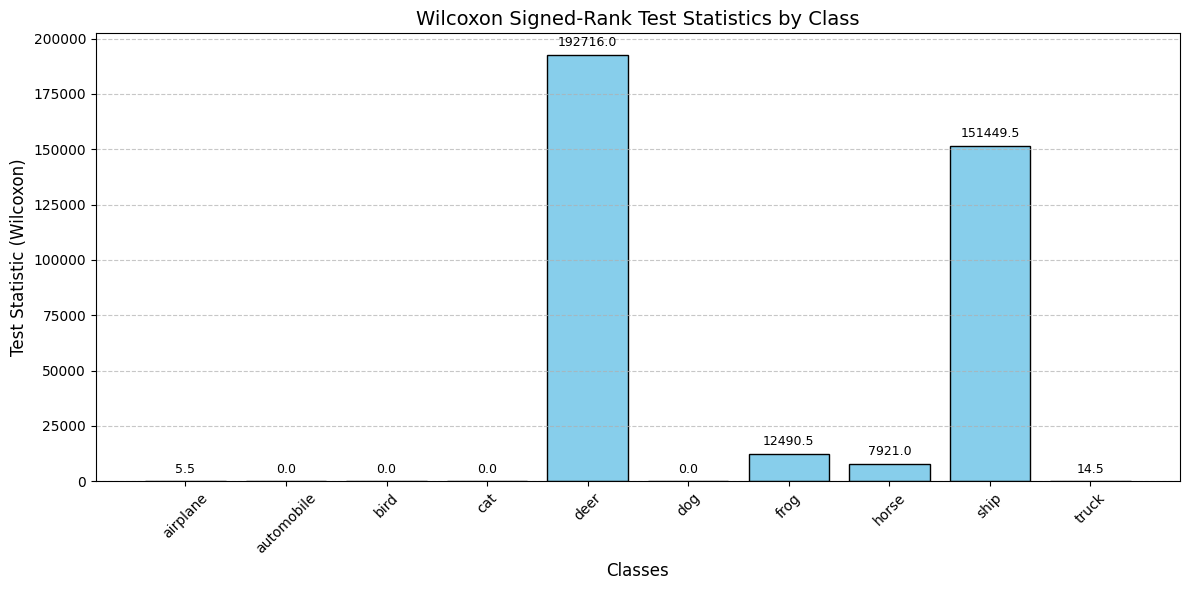

In [24]:
# Data from the Wilcoxon test results
classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
test_statistics = [5.5, 0.0, 0.0, 0.0, 192716.0, 0.0, 12490.5, 7921.0, 151449.5, 14.5]

# Plotting the bar graph
plt.figure(figsize=(12, 6))
plt.bar(classes, test_statistics, color='skyblue', edgecolor='black')
plt.title("Wilcoxon Signed-Rank Test Statistics by Class", fontsize=14)
plt.xlabel("Classes", fontsize=12)
plt.ylabel("Test Statistic (Wilcoxon)", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# adding the values on the graph
for i, stat in enumerate(test_statistics):
    plt.text(i, stat + max(test_statistics) * 0.02, f"{stat:.1f}", ha='center', fontsize=9)

plt.tight_layout()
plt.show()


**CHECKING THE POSITIVE AND NEGATIVE RANK SUM**

In [20]:
# CHECK THE DIRECTION OF THE RANK SUM

for class_idx in range(len(test_dataset.classes)):
    acc_diff = bootstrapped_accuracies_model1[class_idx] - bootstrapped_accuracies_model2[class_idx]

    # Check the signs of differences
    all_positive = np.all(acc_diff > 0)
    all_negative = np.all(acc_diff < 0)

    print(f"Class {test_dataset.classes[class_idx]}:")
    if all_positive:
        print("  All differences are positive.")
    elif all_negative:
        print("  All differences are negative.")
    else:
        print("  Differences are mixed (both positive and negative).")


Class airplane:
  Differences are mixed (both positive and negative).
Class automobile:
  All differences are negative.
Class bird:
  All differences are negative.
Class cat:
  All differences are positive.
Class deer:
  Differences are mixed (both positive and negative).
Class dog:
  All differences are negative.
Class frog:
  Differences are mixed (both positive and negative).
Class horse:
  Differences are mixed (both positive and negative).
Class ship:
  Differences are mixed (both positive and negative).
Class truck:
  Differences are mixed (both positive and negative).


In [21]:
# FIND THE SUM OF THE RANKS

for class_idx in range(len(test_dataset.classes)):
    acc_diff = bootstrapped_accuracies_model1[class_idx] - bootstrapped_accuracies_model2[class_idx]


    non_zero_diff = acc_diff[acc_diff != 0]
    abs_ranks = rankdata(np.abs(non_zero_diff))

    # Sum positive and negative ranks
    positive_ranks_sum = np.sum(abs_ranks[non_zero_diff > 0])
    negative_ranks_sum = np.sum(abs_ranks[non_zero_diff < 0])

    # Print results
    print(f"Class {test_dataset.classes[class_idx]}:")
    print(f"  Positive Ranks Sum: {positive_ranks_sum}")
    print(f"  Negative Ranks Sum: {negative_ranks_sum}")


Class airplane:
  Positive Ranks Sum: 5.5
  Negative Ranks Sum: 500494.5
Class automobile:
  Positive Ranks Sum: 0.0
  Negative Ranks Sum: 500500.0
Class bird:
  Positive Ranks Sum: 0.0
  Negative Ranks Sum: 500500.0
Class cat:
  Positive Ranks Sum: 500500.0
  Negative Ranks Sum: 0.0
Class deer:
  Positive Ranks Sum: 192716.0
  Negative Ranks Sum: 282109.0
Class dog:
  Positive Ranks Sum: 0.0
  Negative Ranks Sum: 500500.0
Class frog:
  Positive Ranks Sum: 12490.5
  Negative Ranks Sum: 478054.5
Class horse:
  Positive Ranks Sum: 7921.0
  Negative Ranks Sum: 490580.0
Class ship:
  Positive Ranks Sum: 321428.5
  Negative Ranks Sum: 151449.5
Class truck:
  Positive Ranks Sum: 500485.5
  Negative Ranks Sum: 14.5


**EXACT P-VALUES FROM THE WILCOXON SIGNED RANK TEST**

In [25]:
for class_idx in range(len(test_dataset.classes)):
  acc_diff = bootstrapped_accuracies_model1[class_idx] - bootstrapped_accuracies_model2[class_idx]
  non_zero_diff = acc_diff[acc_diff != 0]

  # Perform the Wilcoxon test
  stat, p_value = wilcoxon(non_zero_diff, alternative='two-sided')
  print(f"Class {test_dataset.classes[class_idx]}:")
  # print(f"  Test Statistic (Wilcoxon): {stat}")
  print(f"  p value (Wilcoxon): {p_value}")


Class airplane:
  p value (Wilcoxon): 3.203497385464335e-165
Class automobile:
  p value (Wilcoxon): 3.0935422650140584e-165
Class bird:
  p value (Wilcoxon): 3.199285369479734e-165
Class cat:
  p value (Wilcoxon): 3.247562413859079e-165
Class deer:
  p value (Wilcoxon): 3.5668159804608184e-07
Class dog:
  p value (Wilcoxon): 3.211113342174579e-165
Class frog:
  p value (Wilcoxon): 1.450742543698392e-147
Class horse:
  p value (Wilcoxon): 1.0324693062369808e-154
Class ship:
  p value (Wilcoxon): 2.711745956424567e-22
Class truck:
  p value (Wilcoxon): 3.2925997984297416e-165


**MEDIAN OF THE DIFFERENCES OF THE ACCURACIES B/W THE 2 MODELS**

In [ ]:
# Calculate the median of the differences
median_differences = []
for class_idx in range(len(test_dataset.classes)):
    differences = bootstrapped_accuracies_model1[class_idx] - bootstrapped_accuracies_model2[class_idx]
    median_diff = np.median(differences)
    median_differences.append(median_diff)

# Results
print("Median of Differences Between Models:")
for class_idx, median_diff in enumerate(median_differences):
    class_name = test_dataset.classes[class_idx]
    print(f"Class {class_name}: Median Difference = {median_diff:.4f}")


Median of Differences Between Models:
Class airplane: Median Difference = -0.0230
Class automobile: Median Difference = -0.0570
Class bird: Median Difference = -0.1250
Class cat: Median Difference = 0.0590
Class deer: Median Difference = 0.0220
Class dog: Median Difference = -0.0860
Class frog: Median Difference = -0.0090
Class horse: Median Difference = -0.0190
Class ship: Median Difference = 0.0030
Class truck: Median Difference = 0.0250


**FINDING NUMBER OF TIES IN EACH CLASS FROM WILCOXON SIGNED RANK TEST**

In [28]:
# differences between the two models
differences = bootstrapped_accuracies_model1 - bootstrapped_accuracies_model2

# Function to identify and count ties
def count_ties(differences, tolerance=1e-6):
    ties_per_class = {}
    for class_idx, class_differences in enumerate(differences):
        unique_differences, counts = np.unique(np.abs(class_differences), return_counts=True)
        ties = counts[counts > 1]
        num_ties = ties.sum() if ties.size > 0 else 0
        ties_per_class[f"Class {test_dataset.classes[class_idx]}"] = num_ties
    return ties_per_class

# Count ties for each class
ties_per_class = count_ties(differences)

# results
print("Number of ties for each class:")
for class_name, num_ties in ties_per_class.items():
    print(f"{class_name}: {num_ties} ties")



Number of ties for each class:
Class airplane: 974 ties
Class automobile: 996 ties
Class bird: 980 ties
Class cat: 955 ties
Class deer: 998 ties
Class dog: 991 ties
Class frog: 996 ties
Class horse: 992 ties
Class ship: 988 ties
Class truck: 987 ties
